# Execution Probability - Part 2 - Fits

In [2]:
# Fits, Weibull, Beta-Binomial, Exponential

library(DiscreteWeibull)
library(fitdistrplus)
library(gplots)

sep_20_normalized_q <- read.csv(file="Quantities/sep_20_normalized_quantities.csv")
nov_01_normalized_q <- read.csv(file="Quantities/nov_01_normalized_quantities.csv")
nov_02_normalized_q <- read.csv(file="Quantities/nov_02_normalized_quantities.csv")
nov_03_normalized_q <- read.csv(file="Quantities/nov_03_normalized_quantities.csv")

Loading required package: Rsolnp
Loading required package: MASS
Loading required package: survival

Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess



## Count Data Features

Weibull, Beta - Binomial and Exponential Distributions require us to have a count data on the zeroth tick. As a result, the count data is from 0 to 14 for total 15 ticks. Additionally, the data is perturbed for Weibull Distribution, instead of having counts at 0, we have count data for a value which is close to 0.

In [3]:
# Setting Data

# Mean Data
daily_q <- list()
daily_q[[1]] <- sep_20_normalized_q
daily_q[[2]] <- nov_01_normalized_q
daily_q[[3]] <- nov_02_normalized_q
daily_q[[4]] <- nov_03_normalized_q

# Sum of Squares Differences

exp_differences <- c()
bb_differences <- c()

discrete_wei_L1 <- c()
geometric_L1 <- c()
bbinom_L1 <- c()

### MLE for Geometric Distribution

In [4]:
# Maximum Likelihood Estimator for Exponential Distribution
# This function returns lambda estimation
# lambda = 1 / mean

mle_exp <- function(count_data) {
    return(1/mean(count_data))
}

### MLE for Beta-Binomial Distribution

In [5]:
loglik_bb <- function(x, n, par) {
  -sum(log(choose(n, x)) + log(beta(x + par[1], n - x + par[2])) - log(beta(par[1], par[2])))
}

bb_pmf <- function(n, k, a, b) {
  return(choose(n,k)*beta(k+a, n-k+b)/beta(a,b))
}

bb_mle_optimizer <- function(data, n) {
    
    # Using Optim Function
    # par[1] is alpha
    # par[2] is beta
    
    parameters = optim(fn=loglik_bb, par = c(1,1), x = data, n = n)$par
    a = parameters[1]
    b = parameters[2]
    
    return(c(a, b))
}

## Distribution Fitting

- Geometric Distribution
- Beta-Binomial Distribution
- Discrete Weibull Distribution

### Mean Limit and Mean Cancel Orders, Probability Mass Functions

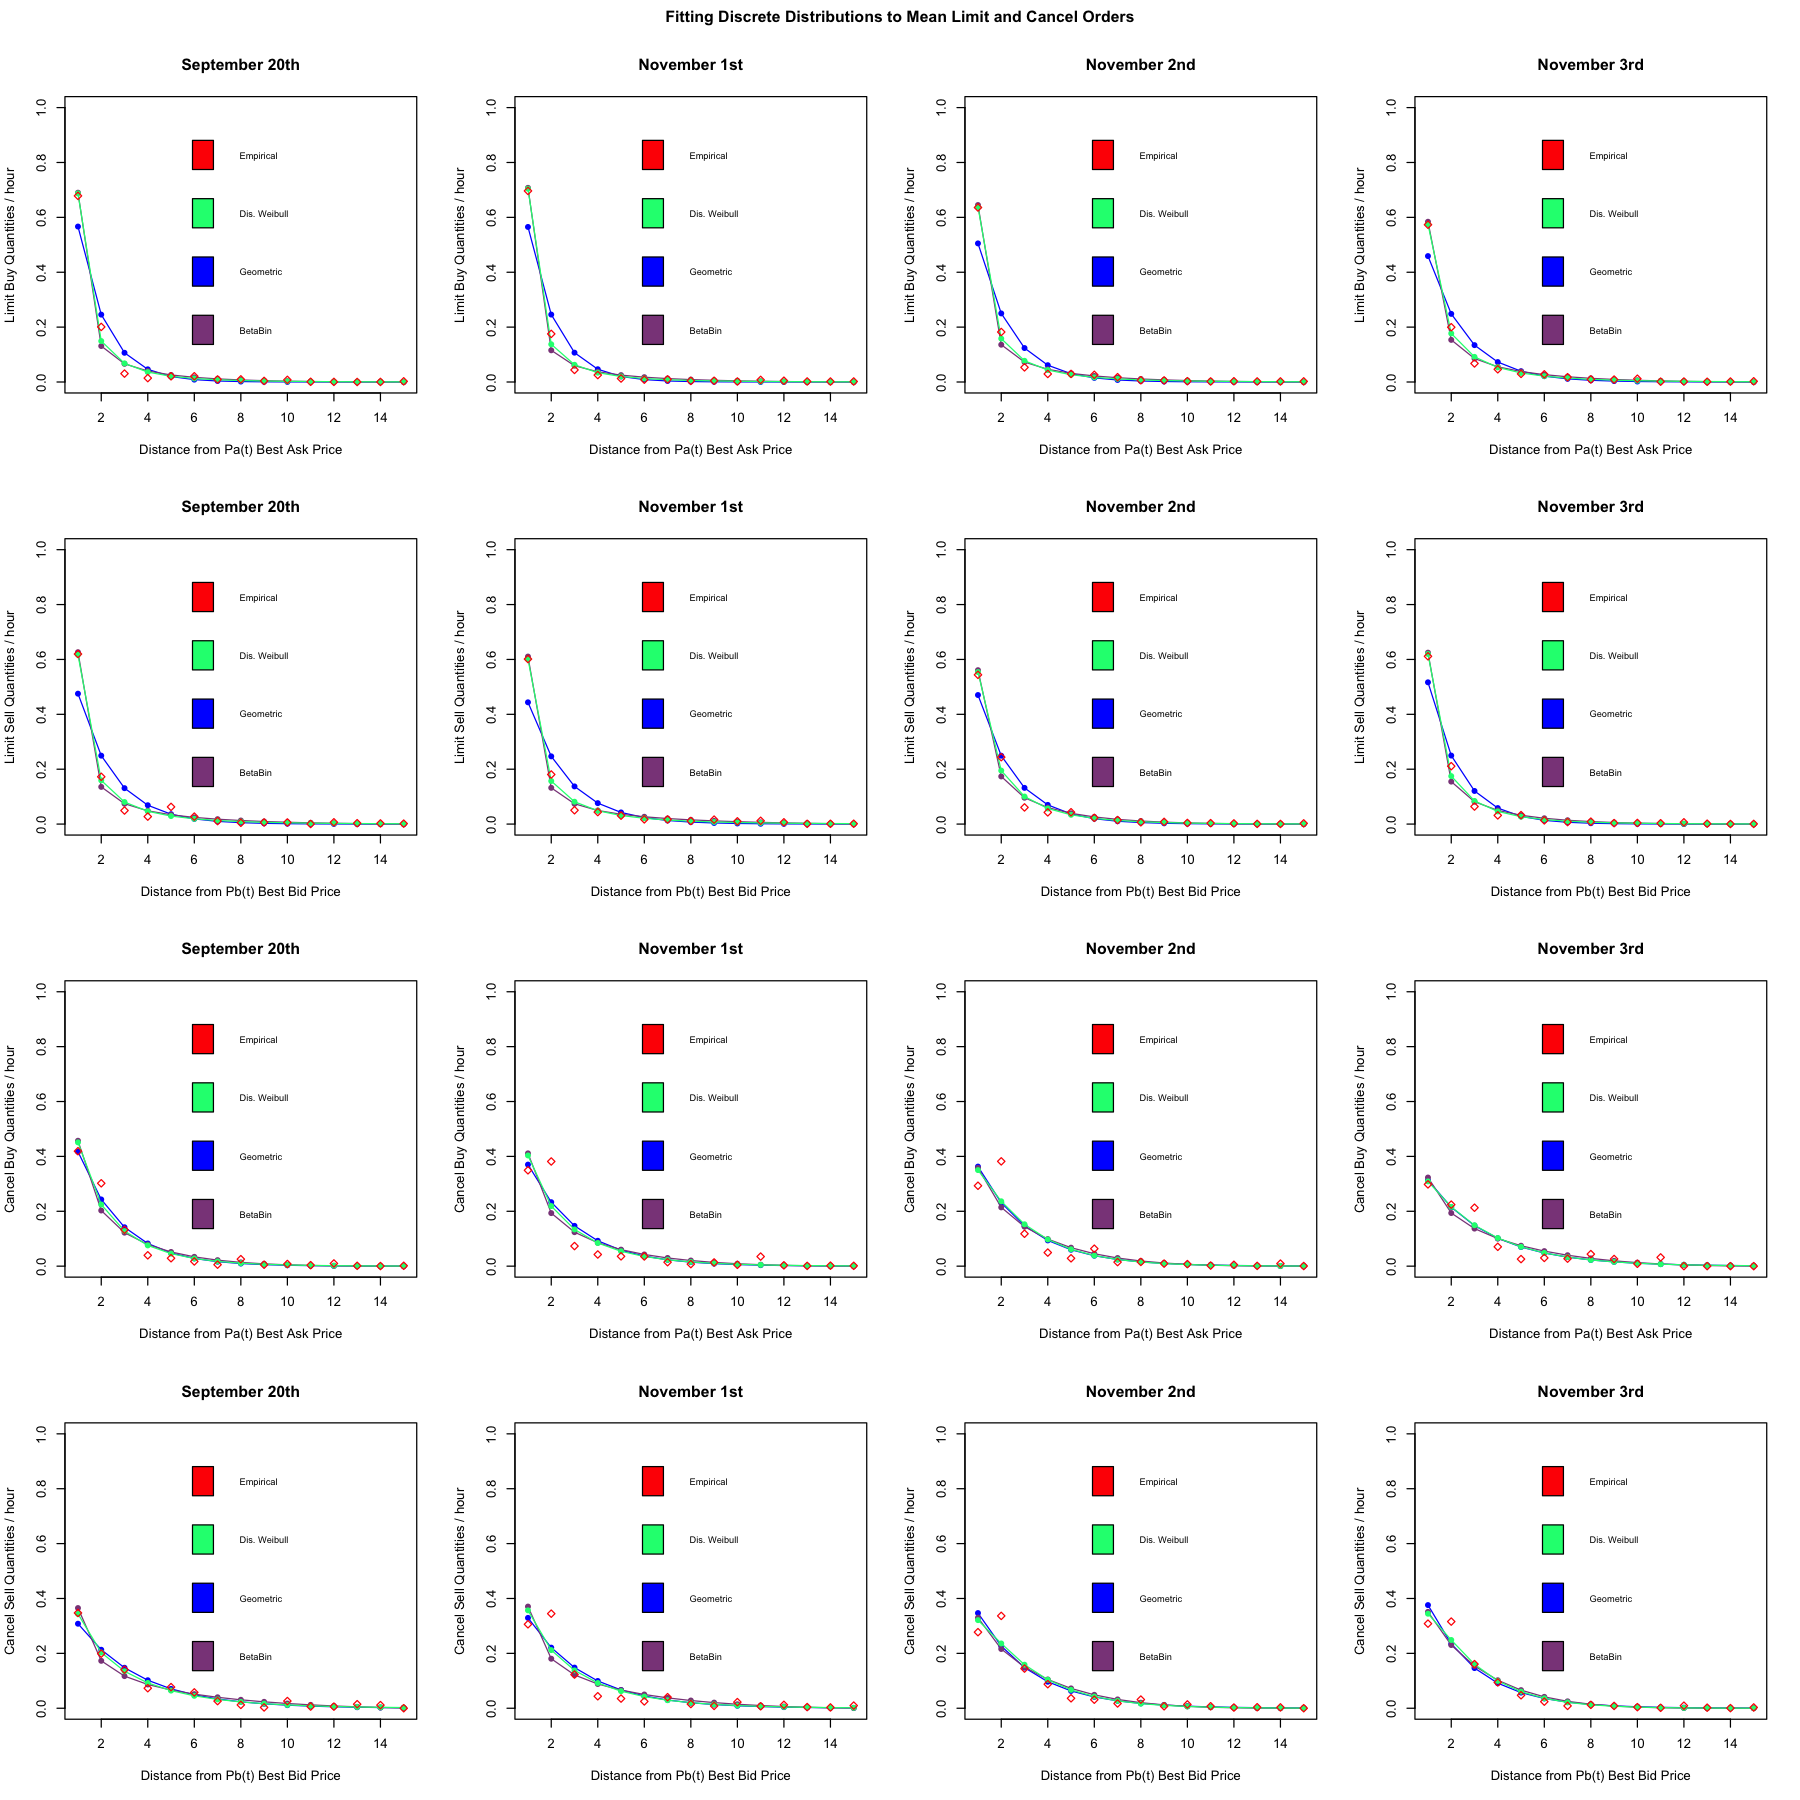

In [6]:
options(warn=-1)

# PDF
names <- c("September 20th", "November 1st", "November 2nd", "November 3rd")
order <- c("Limit Buy", "Limit Sell", "Cancel Buy", "Cancel Sell")
prices <- c("Pb(t) Best Bid Price", "Pa(t) Best Ask Price")
par(mfrow = c(4, 4), oma=c(0,0,2,0))
options(repr.plot.width=15, repr.plot.height=15)
ticks <- 1:15

for (i in 1:4) {
    for (k in 1:4) {
        
        count_data <- rep(ticks, daily_q[[k]][i, 2:16])
        
        # Geometric Distribution
        
        p <- mle_exp(count_data)
        
        plot(1:15, ((1-p)^(0:14))*p, 
             col="blue", pch=16, ylim=range(c(0,1)), 
             axes = FALSE, xlab = "", ylab = "")

        lines(1:15, ((1-p)^(0:14))*p, col="blue")
        
        diff <- sum(abs((((1-p)^(0:14))*p) - (daily_q[[k]][i, 2:16]/sum(daily_q[[k]][i, 2:16]))))
        geometric_L1 <- c(geometric_L1, diff)
        
        # Beta - Binomial Distribtuion
        
        par(new = TRUE)
        
        params <- bb_mle_optimizer(rep(0:14, daily_q[[k]][i, 2:16]), 14)
        a <- params[1]
        b <- params[2]
        
        plot(1:15, bb_pmf(14,0:14,a,b), 
             col="orchid4", pch=16, ylim=range(c(0,1)), 
             axes = FALSE, xlab = "", ylab = "")

        lines(1:15, bb_pmf(14,0:14,a,b), col="orchid4")
        
        diff <- sum(abs(bb_pmf(14,0:14,a,b) - (daily_q[[k]][i, 2:16]/sum(daily_q[[k]][i, 2:16]))))
        bbinom_L1 <- c(bbinom_L1, diff)
        
        # Discrete Weibull Distribution
        
        par(new = TRUE)
        
        params <- estdweibull(count_data, method = "ML", zero = FALSE, eps = 1e-04, nmax=1000)
        q <- params[1]
        b <- params[2]
        
        plot(1:15, q^((0:14)^b) - q^((1:15)^b), 
             col="springgreen", pch=16, ylim=range(c(0,1)), 
             axes = FALSE, xlab = "", ylab = "")
        
        lines(1:15, q^((0:14)^b) - q^((1:15)^b), col="springgreen")
        
        diff <- sum(abs((q^((0:14)^b) - q^((1:15)^b)) - (daily_q[[k]][i, 2:16]/sum(daily_q[[k]][i, 2:16]))))
        discrete_wei_L1 <- c(discrete_wei_L1, diff)
        
        # Density
        
        par(new = TRUE)
        
        plot(1:15, daily_q[[k]][i, 2:16]/sum(daily_q[[k]][i, 2:16]),col="red", 
             xlab = paste("Distance from", prices[(i %% 2)+1]),
             ylab = paste(order[i], "Quantities / hour"), main = names[k],
             pch=23, ylim=range(c(0,1)))
        
        legend("topright",
               c("Empirical","Dis. Weibull", "Geometric", "BetaBin"),
               fill=c("red","springgreen", "blue", "orchid4"),
               cex=0.7, bty = "n",
               xjust = 0, yjust = 0)
    }
}
        
title("Fitting Discrete Distributions to Mean Limit and Cancel Orders", outer = TRUE) 
options(warn=0)

## Fit Tests: L1 norms of difference in PMFs of Mean Limit and Cancel Orders

<img src="mean_ord.png" style="width: 1000px;"/>

### Fit Scores

For fit tests on mean orders, hourly limit orders and hourly cancel orders. We divide each row in the same day with the minimum value in that row and we find the scores. 

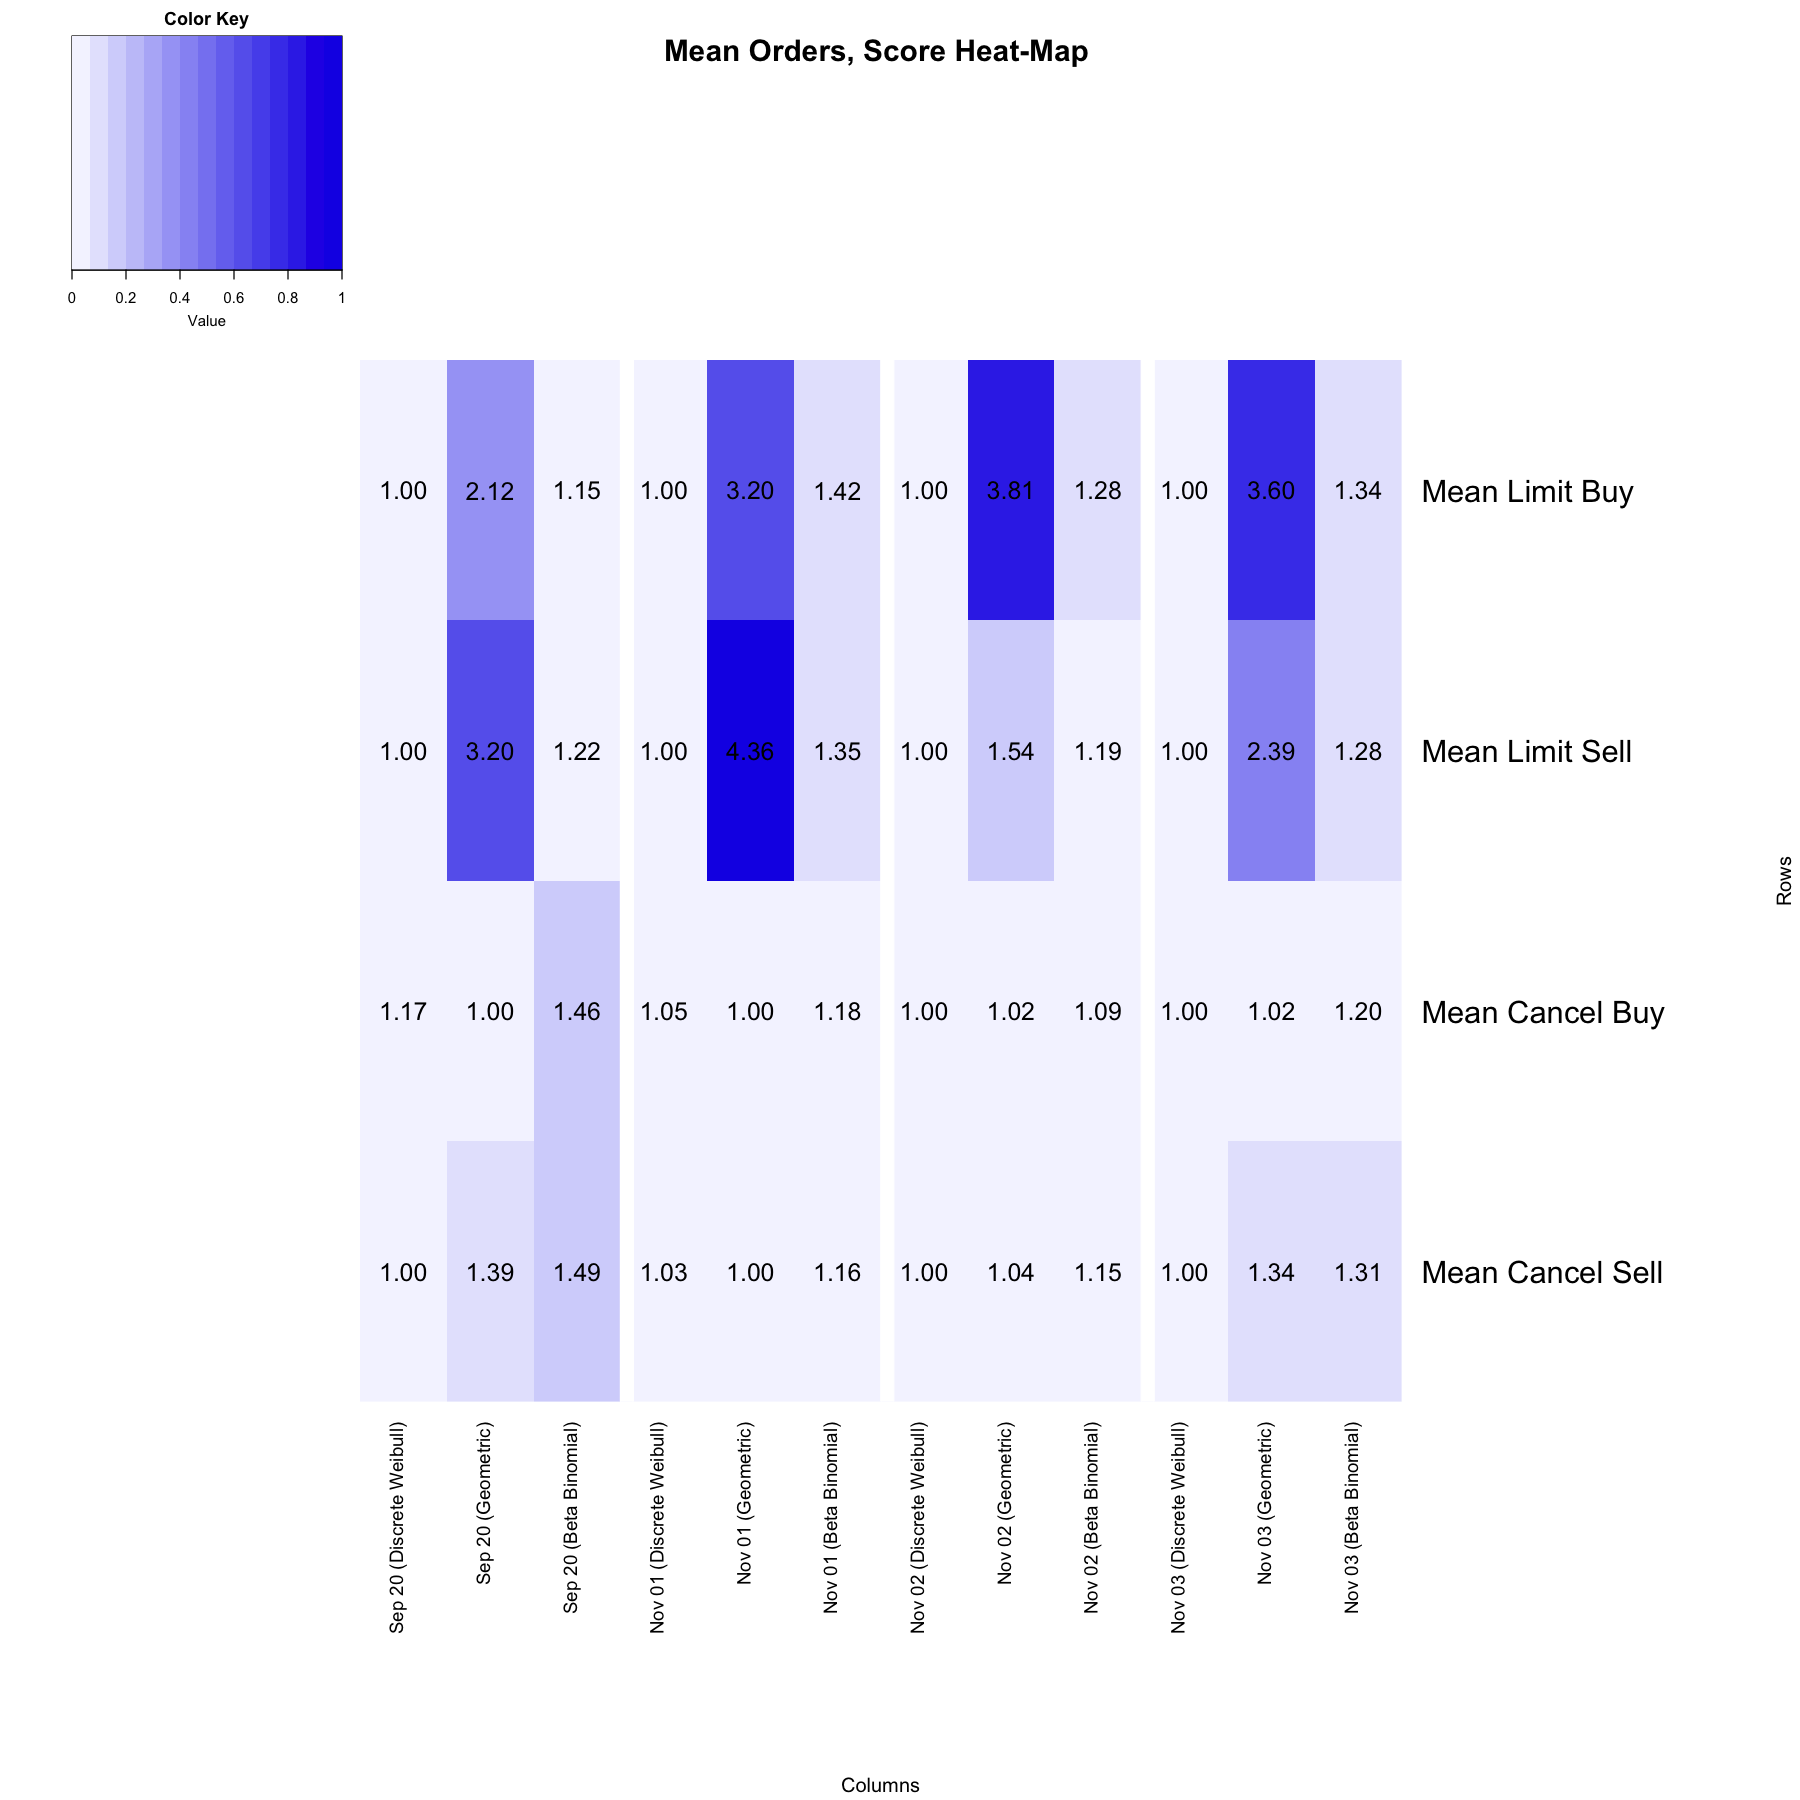

In [7]:
difs <- c()

for (i in 1:16) {
    min <- min(discrete_wei_L1[i], geometric_L1[i], bbinom_L1[i])
    difs <- c(difs, discrete_wei_L1[i]/min, geometric_L1[i]/min, bbinom_L1[i]/min)
}

mean_sd_mat = matrix(difs,
                     nrow=4,
                     ncol=12,
                     byrow = TRUE
                    )

xval <- formatC(mean_sd_mat, format="f", digits=2)
pal <- colorRampPalette(c(rgb(0.96,0.96,1), rgb(0.1,0.1,0.9)), space = "rgb")

mean_sd_mat <- (mean_sd_mat - min(mean_sd_mat)) / (max(mean_sd_mat) - min(mean_sd_mat))

dimnames(mean_sd_mat) = list(
    c("Mean Limit Buy",
     "Mean Limit Sell",
     "Mean Cancel Buy",
     "Mean Cancel Sell"),         # row names
    c("Sep 20 (Discrete Weibull)", "Sep 20 (Geometric)", "Sep 20 (Beta Binomial)",
      "Nov 01 (Discrete Weibull)", "Nov 01 (Geometric)", "Nov 01 (Beta Binomial)",
      "Nov 02 (Discrete Weibull)", "Nov 02 (Geometric)", "Nov 02 (Beta Binomial)",
      "Nov 03 (Discrete Weibull)", "Nov 03 (Geometric)", "Nov 03 (Beta Binomial)"
     )
)

#Plot the matrix
x_hm <- heatmap.2(mean_sd_mat, 
                  Rowv=FALSE, 
                  Colv=FALSE, 
                  dendrogram="none", 
                  main="Mean Orders, Score Heat-Map ", 
                  xlab="Columns", 
                  ylab="Rows", 
                  col=pal, density.info = "none",
                  tracecol="#303030", trace="none", 
                  cellnote=xval, notecol="black", notecex=1.5, keysize = 1, margins=c(20, 20),
                 colsep=c(3,6,9), sepwidth=c(0.15))

### Hourly Limit Buy Orders, Probability Mass Functions

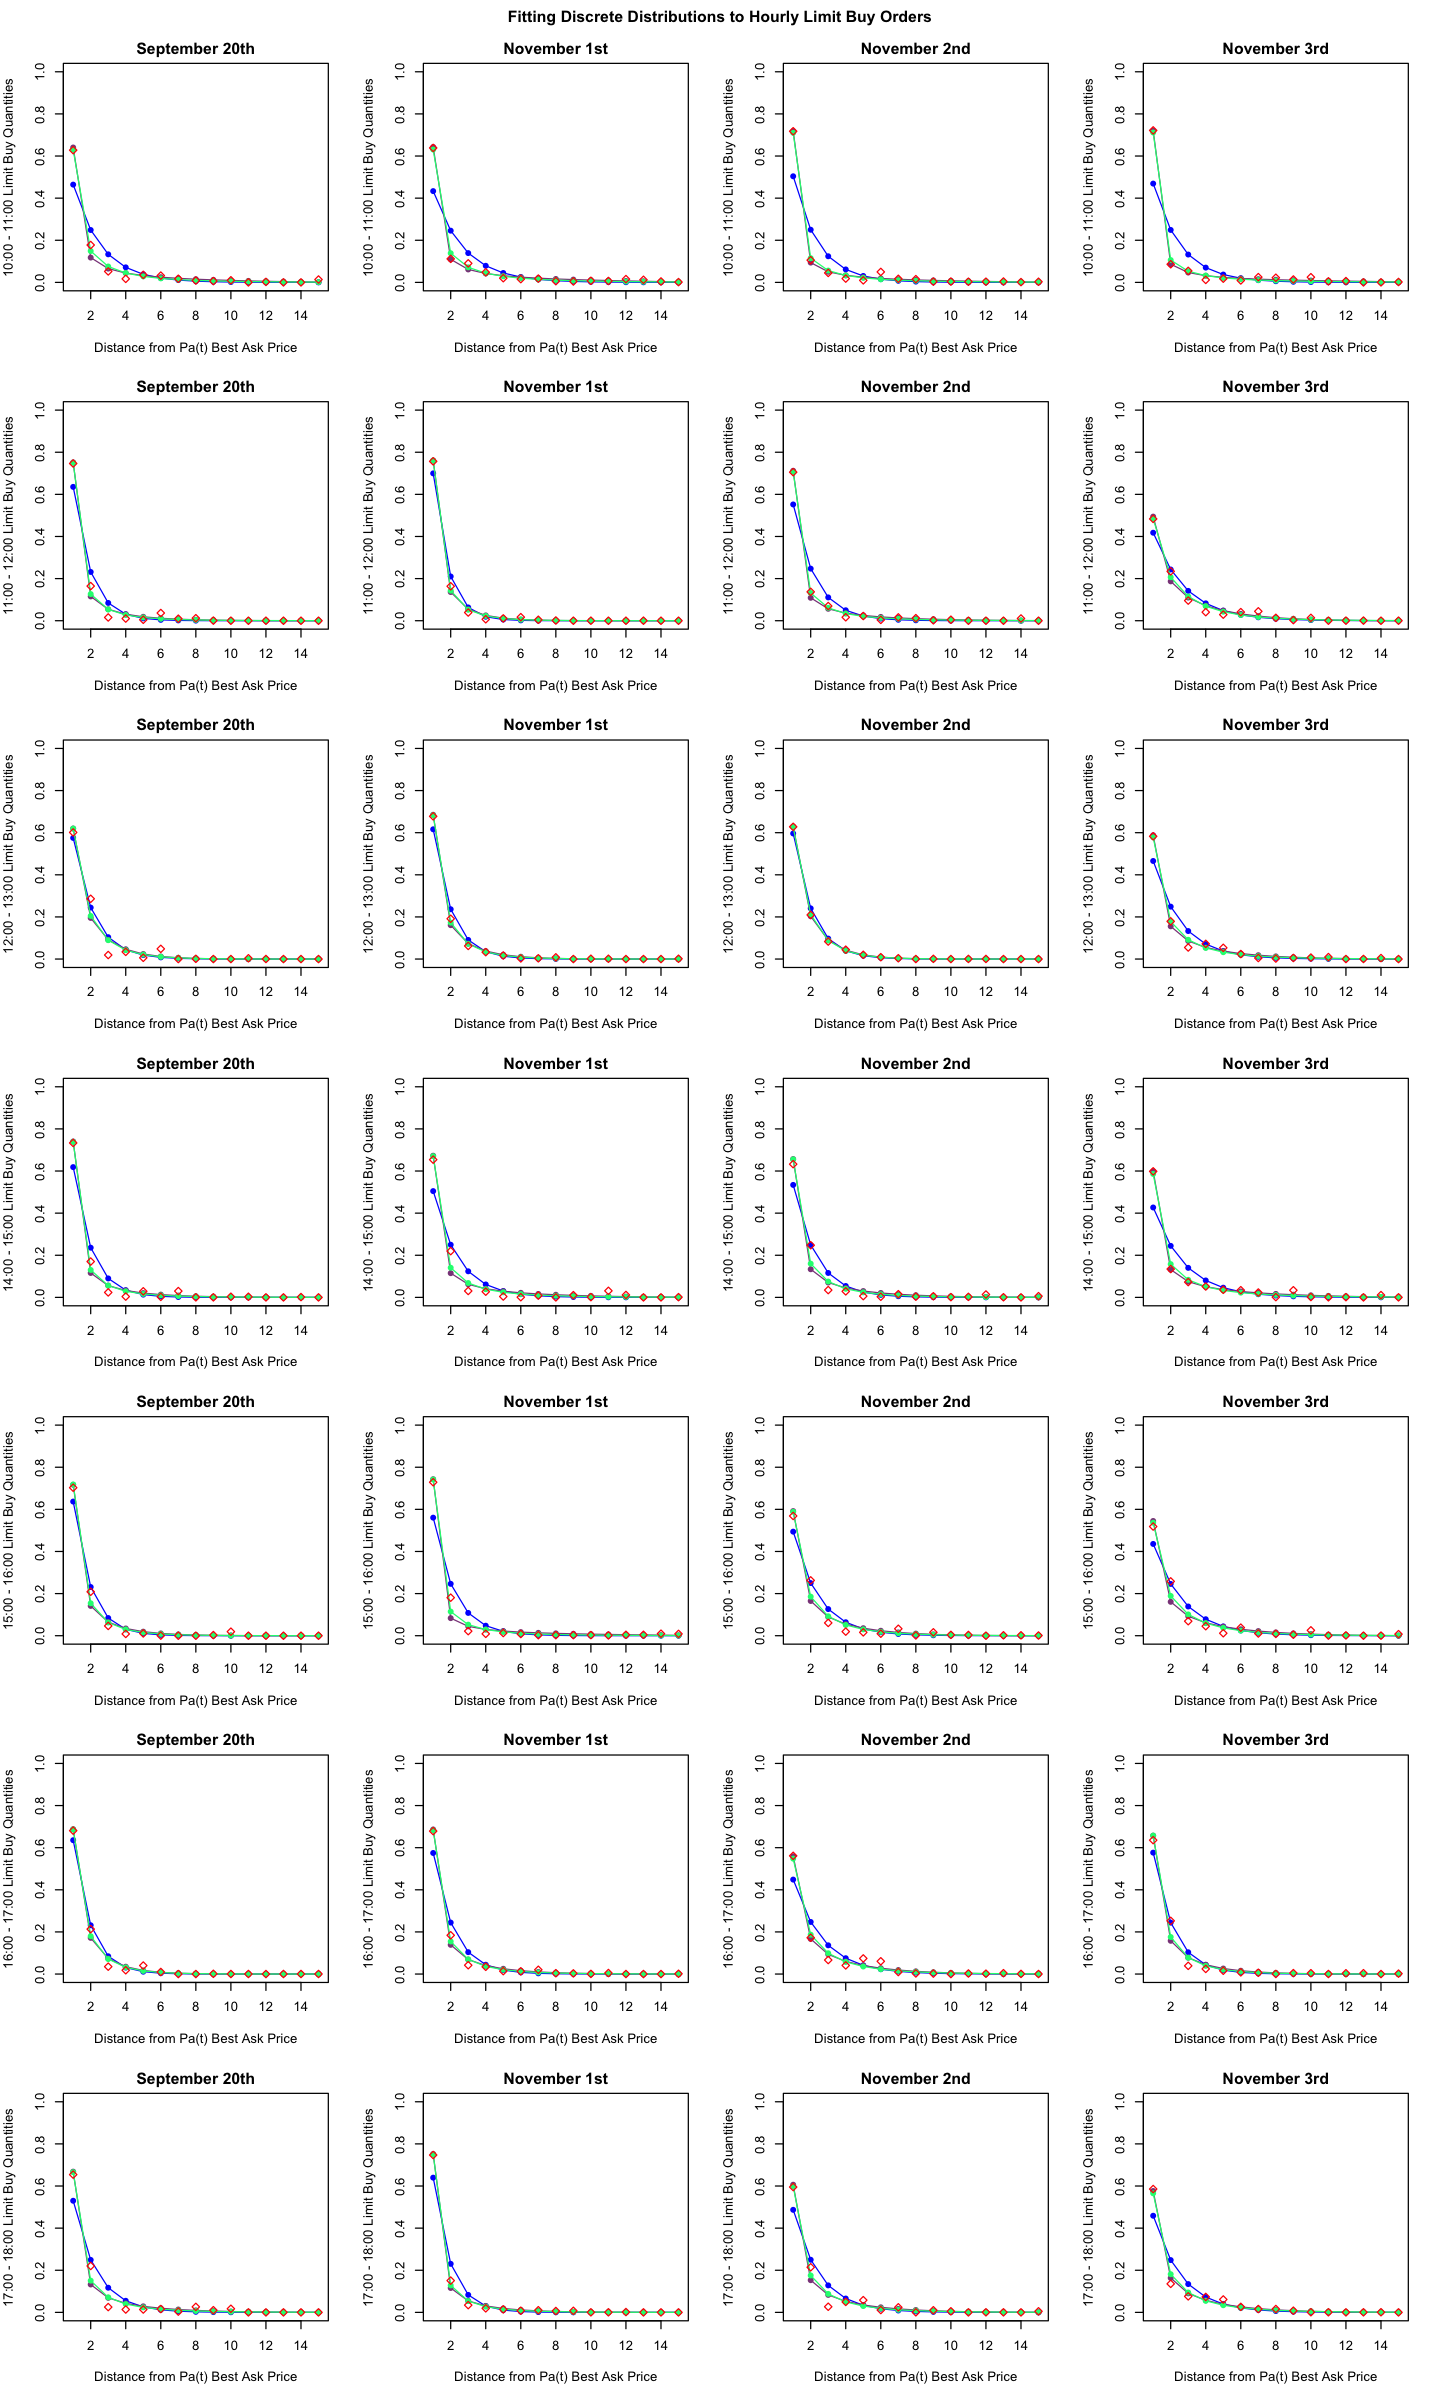

In [8]:
options(warn=-1)

discrete_wei_L1 <- c()
geometric_L1 <- c()
bbinom_L1 <- c()

# PDF
options(repr.plot.width=12, repr.plot.height=20)
names <- c("September 20th", "November 1st", 
           "November 2nd", "November 3rd")
hours <- c('10:00 - 11:00', '11:00 - 12:00', '12:00 - 13:00', '14:00 - 15:00', '15:00 - 16:00', '16:00 - 17:00',
        '17:00 - 18:00')
par(mfrow = c(7, 4), oma=c(0,0,2,0))  

for (i in 1:7) {
    for (k in 1:4) {
        par(mar=c(5,4,2,2))
        count_data <- rep(ticks, daily_q[[k]][i+4, 2:16])
        
        # Geometric Distribution
        
        p <- mle_exp(count_data)
        
        plot(1:15, ((1-p)^(0:14))*p, 
             col="blue", pch=16, ylim=range(c(0,1)), 
             axes = FALSE, xlab = "", ylab = "")

        lines(1:15, ((1-p)^(0:14))*p, col="blue")
        
        diff <- sum(abs((((1-p)^(0:14))*p) - (daily_q[[k]][i+4, 2:16]/sum(daily_q[[k]][i+4, 2:16]))))
        geometric_L1 <- c(geometric_L1, diff)
       
        # Beta - Binomial Distribtuion
        
        par(new = TRUE)
        
        params <- bb_mle_optimizer(rep(0:14, daily_q[[k]][i+4, 2:16]), 14)
        a <- params[1]
        b <- params[2]
        
        plot(1:15, bb_pmf(14,0:14,a,b), 
             col="orchid4", pch=16, ylim=range(c(0,1)), 
             axes = FALSE, xlab = "", ylab = "")

        lines(1:15, bb_pmf(14,0:14,a,b), col="orchid4")
        
        diff <- sum(abs(bb_pmf(14,0:14,a,b) - (daily_q[[k]][i+4, 2:16]/sum(daily_q[[k]][i+4, 2:16]))))
        bbinom_L1 <- c(bbinom_L1, diff)
        
        # Discrete Weibull Distribution
        
        par(new = TRUE)
        
        params <- estdweibull(count_data, method = "ML", zero = FALSE, eps = 1e-04, nmax=1000)
        q <- params[1]
        b <- params[2]
        
        plot(1:15, q^((0:14)^b) - q^((1:15)^b), 
             col="springgreen", pch=16, ylim=range(c(0,1)), 
             axes = FALSE, xlab = "", ylab = "")
        
        lines(1:15, q^((0:14)^b) - q^((1:15)^b), col="springgreen")
        
        diff <- sum(abs((q^((0:14)^b) - q^((1:15)^b)) - (daily_q[[k]][i+4, 2:16]/sum(daily_q[[k]][i+4, 2:16]))))
        discrete_wei_L1 <- c(discrete_wei_L1, diff)
        
        # Density
        
        par(new = TRUE)
        
        plot(1:15, daily_q[[k]][i+4, 2:16]/sum(daily_q[[k]][i+4, 2:16]),col="red", 
             xlab = "Distance from Pa(t) Best Ask Price",
             ylab = paste(hours[i], "Limit Buy Quantities"), main = names[k],
             pch=23, ylim=range(c(0,1)))
            
    }
}
        
title("Fitting Discrete Distributions to Hourly Limit Buy Orders", outer = TRUE) 

options(warn=0)

### Fit Tests: L1 norms of difference in PMFs of Hourly Limit Buy Orders

<img src="lim_buy.png" style="width: 1000px;"/>

### Fit Scores

For fit tests on mean orders, hourly limit orders and hourly cancel orders. We divide each row in the same day with the minimum value in that row and we find the scores. 

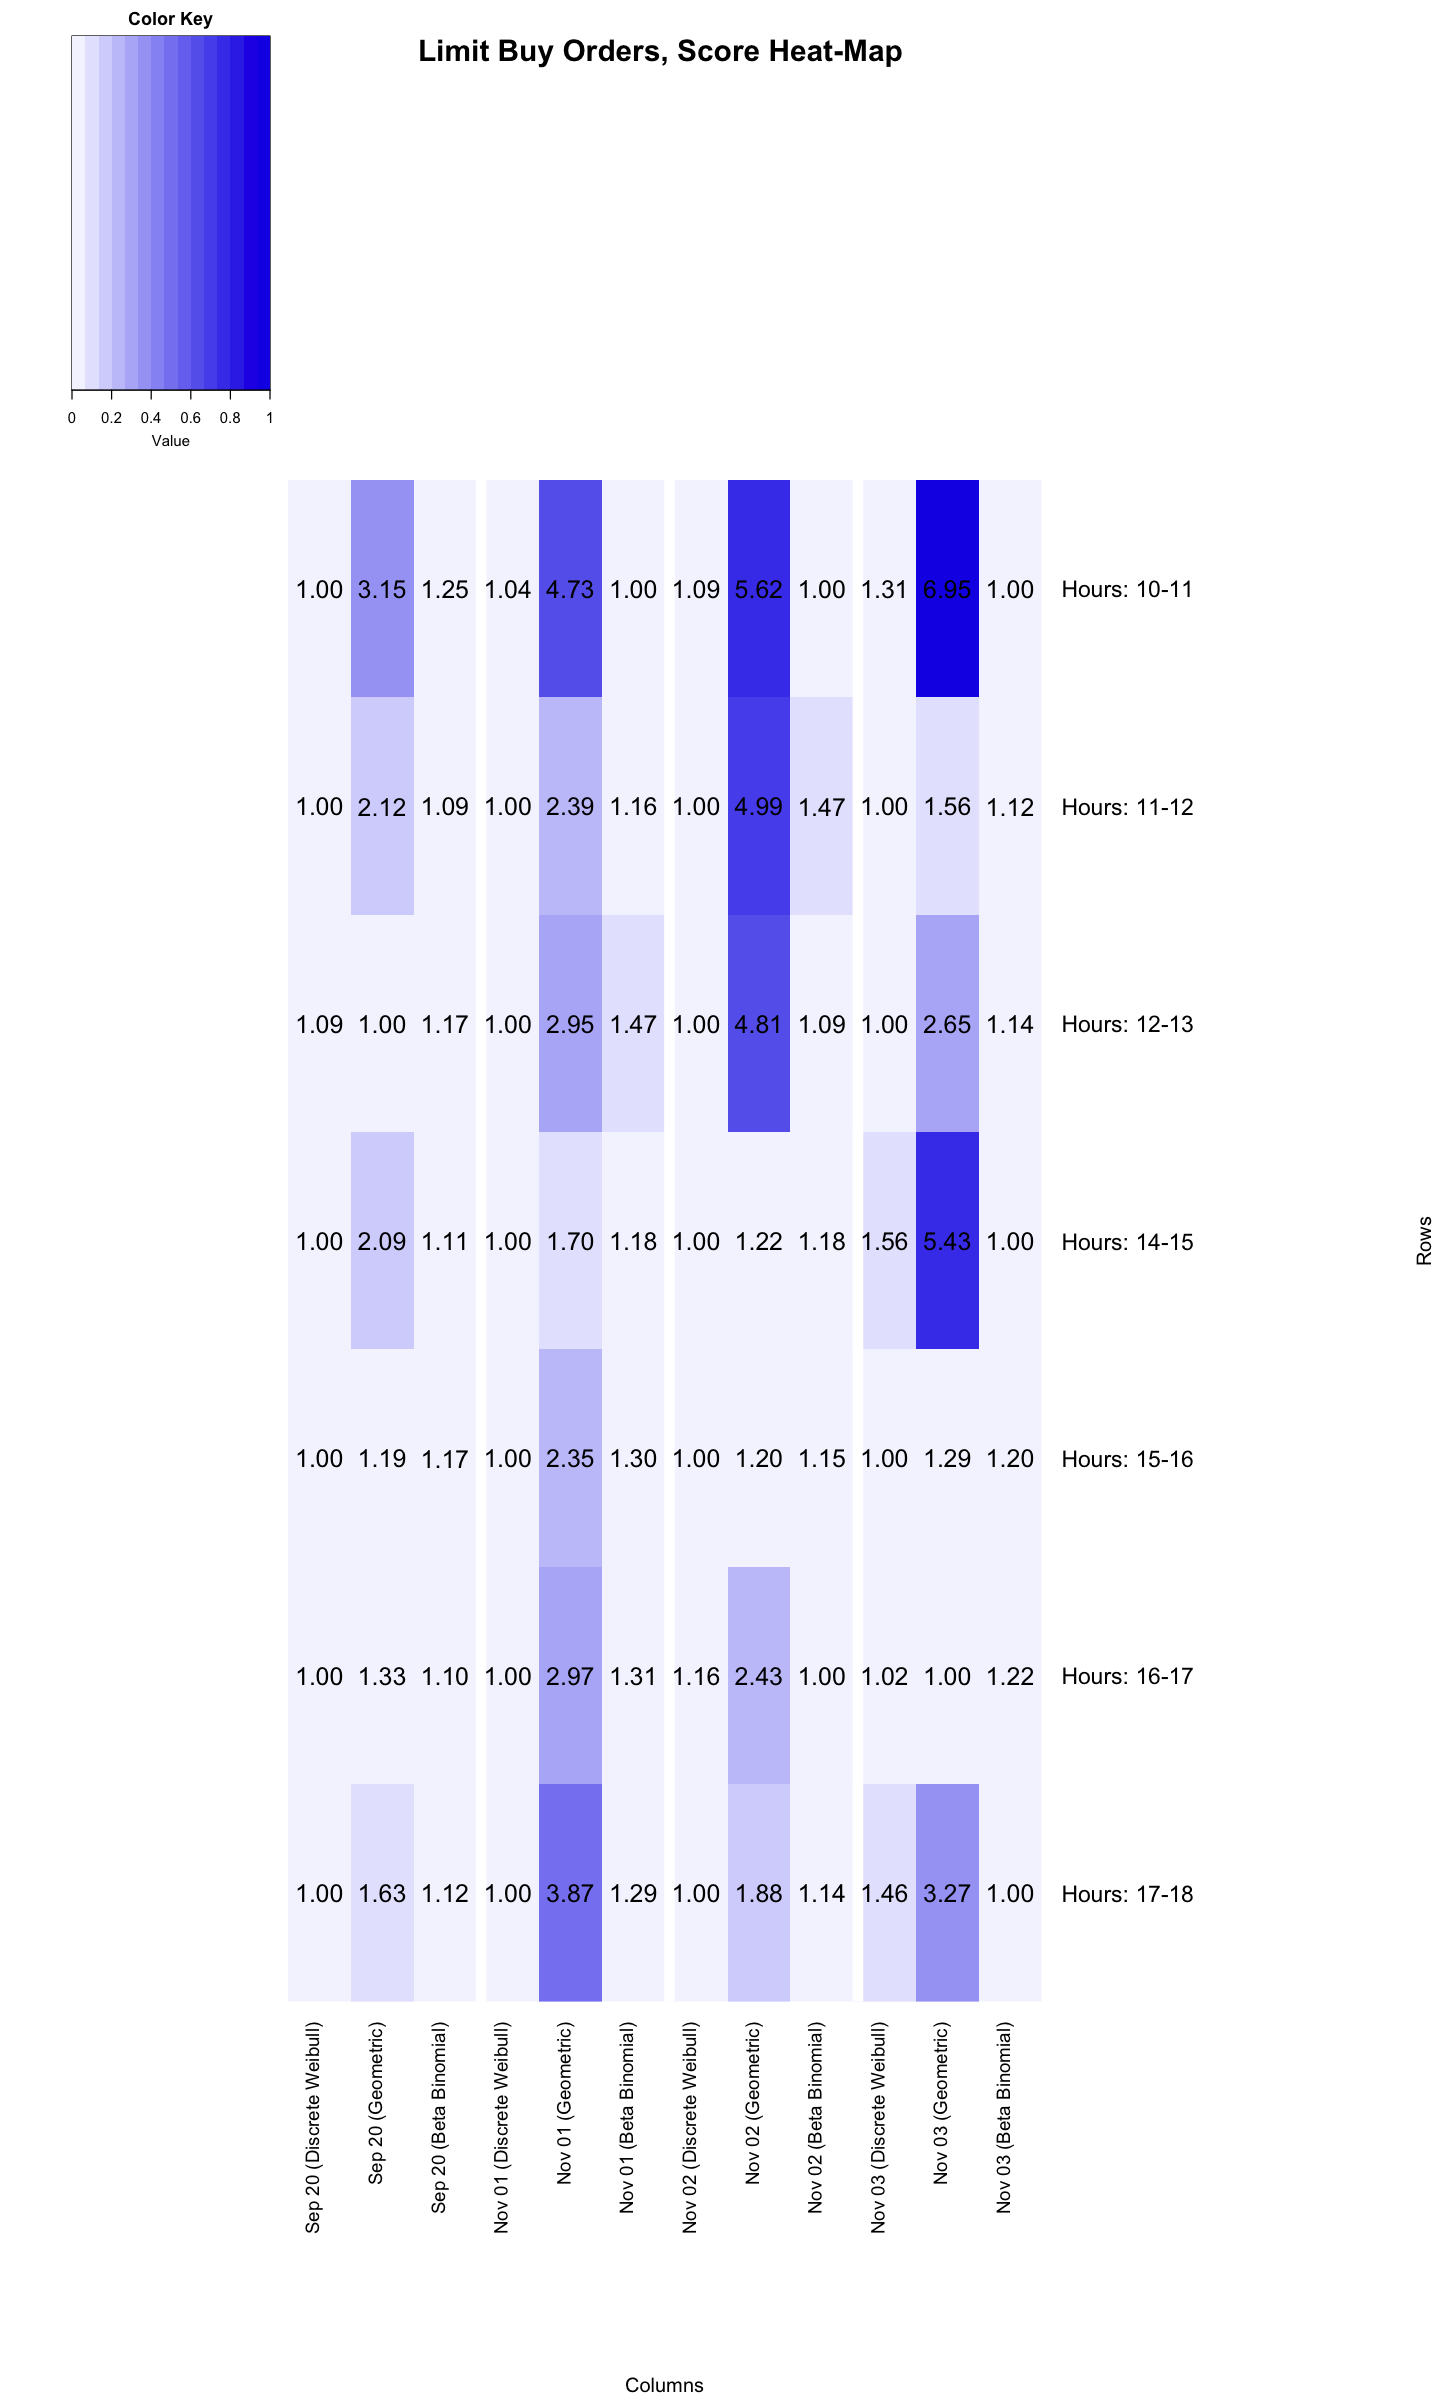

In [9]:
difs <- c()

for (i in 1:28) {
    min <- min(discrete_wei_L1[i], geometric_L1[i], bbinom_L1[i])
    difs <- c(difs, discrete_wei_L1[i]/min, geometric_L1[i]/min, bbinom_L1[i]/min)
}

mean_sd_mat = matrix(difs,
                     nrow=7,
                     ncol=12,
                     byrow = TRUE
                    )

xval <- formatC(mean_sd_mat, format="f", digits=2)
pal <- colorRampPalette(c(rgb(0.96,0.96,1), rgb(0.1,0.1,0.9)), space = "rgb")

mean_sd_mat <- (mean_sd_mat - min(mean_sd_mat)) / (max(mean_sd_mat) - min(mean_sd_mat))

dimnames(mean_sd_mat) = list(
    c("Hours: 10-11",
     "Hours: 11-12",
     "Hours: 12-13",
     "Hours: 14-15",
     "Hours: 15-16",
     "Hours: 16-17",
     "Hours: 17-18"),         # row names
    c("Sep 20 (Discrete Weibull)", "Sep 20 (Geometric)", "Sep 20 (Beta Binomial)",
      "Nov 01 (Discrete Weibull)", "Nov 01 (Geometric)", "Nov 01 (Beta Binomial)",
      "Nov 02 (Discrete Weibull)", "Nov 02 (Geometric)", "Nov 02 (Beta Binomial)",
      "Nov 03 (Discrete Weibull)", "Nov 03 (Geometric)", "Nov 03 (Beta Binomial)"
     )
)



#Plot the matrix
x_hm <- heatmap.2(mean_sd_mat, 
                  Rowv=FALSE, 
                  Colv=FALSE, 
                  dendrogram="none", 
                  main="Limit Buy Orders, Score Heat-Map ", 
                  xlab="Columns", 
                  ylab="Rows", 
                  col=pal, density.info = "none",
                  tracecol="#303030", trace="none", 
                  cellnote=xval, notecol="black", notecex=1.5, keysize = 1, margins=c(20, 20),
                 colsep=c(3,6,9), sepwidth=c(0.15))

### Hourly Limit Sell Orders, Probability Mass Functions

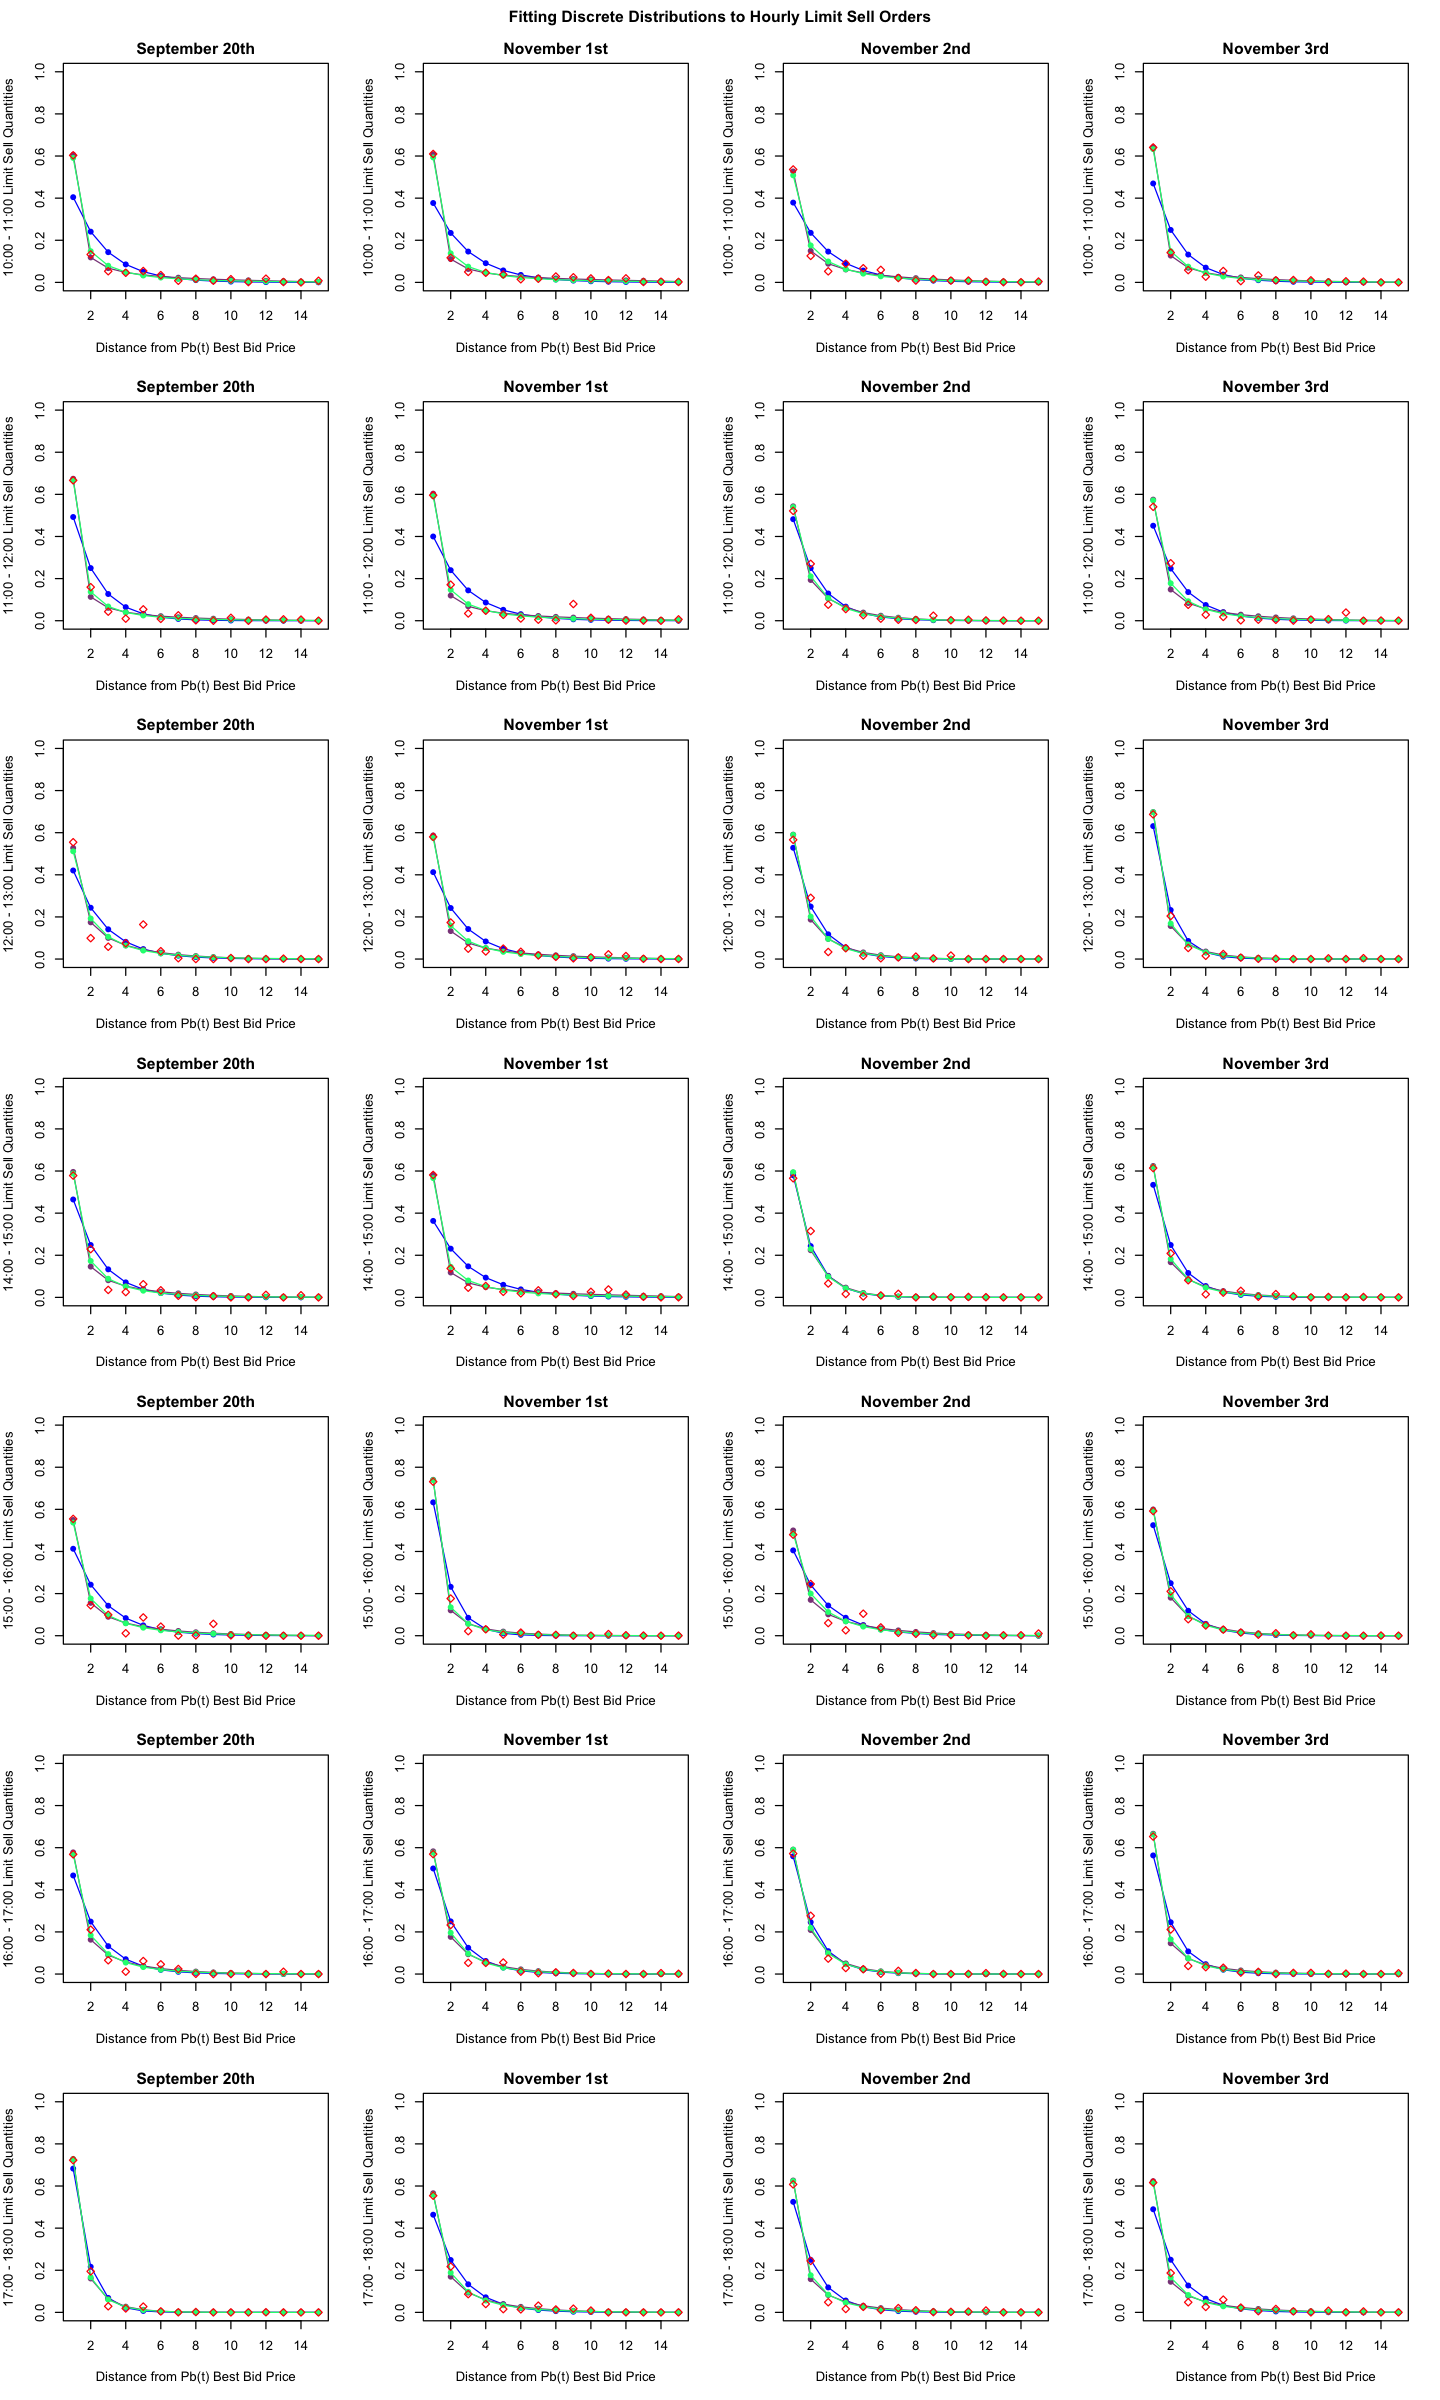

In [10]:
options(warn=-1)

discrete_wei_L1 <- c()
geometric_L1 <- c()
bbinom_L1 <- c()

# PDF
options(repr.plot.width=12, repr.plot.height=20)
names <- c("September 20th", "November 1st", 
           "November 2nd", "November 3rd")
hours <- c('10:00 - 11:00', '11:00 - 12:00', '12:00 - 13:00', '14:00 - 15:00', '15:00 - 16:00', '16:00 - 17:00',
        '17:00 - 18:00')
par(mfrow = c(7, 4), oma=c(0,0,2,0))  

for (i in 1:7) {
    for (k in 1:4) {
        par(mar=c(5,4,2,2))
        count_data <- rep(ticks, daily_q[[k]][i+11, 2:16])
        
        # Geometric Distribution
        
        p <- mle_exp(count_data)
        
        plot(1:15, ((1-p)^(0:14))*p, 
             col="blue", pch=16, ylim=range(c(0,1)), 
             axes = FALSE, xlab = "", ylab = "")

        lines(1:15, ((1-p)^(0:14))*p, col="blue")
        
        diff <- sum(abs((((1-p)^(0:14))*p) - (daily_q[[k]][i+11, 2:16]/sum(daily_q[[k]][i+11, 2:16]))))
        geometric_L1 <- c(geometric_L1, diff)
       
        # Beta - Binomial Distribtuion
        
        par(new = TRUE)
        
        params <- bb_mle_optimizer(rep(0:14, daily_q[[k]][i+11, 2:16]), 14)
        a <- params[1]
        b <- params[2]
        
        plot(1:15, bb_pmf(14,0:14,a,b), 
             col="orchid4", pch=16, ylim=range(c(0,1)), 
             axes = FALSE, xlab = "", ylab = "")

        lines(1:15, bb_pmf(14,0:14,a,b), col="orchid4")
        
        diff <- sum(abs(bb_pmf(14,0:14,a,b) - (daily_q[[k]][i+11, 2:16]/sum(daily_q[[k]][i+11, 2:16]))))
        bbinom_L1 <- c(bbinom_L1, diff)
        
        # Discrete Weibull Distribution
        
        par(new = TRUE)
        
        params <- estdweibull(count_data, method = "ML", zero = FALSE, eps = 1e-04, nmax=1000)
        q <- params[1]
        b <- params[2]
        
        plot(1:15, q^((0:14)^b) - q^((1:15)^b), 
             col="springgreen", pch=16, ylim=range(c(0,1)), 
             axes = FALSE, xlab = "", ylab = "")
        
        lines(1:15, q^((0:14)^b) - q^((1:15)^b), col="springgreen")
        
        diff <- sum(abs((q^((0:14)^b) - q^((1:15)^b)) - (daily_q[[k]][i+11, 2:16]/sum(daily_q[[k]][i+11, 2:16]))))
        discrete_wei_L1 <- c(discrete_wei_L1, diff)
        
        # Density
        
        par(new = TRUE)
        
        plot(1:15, daily_q[[k]][i+11, 2:16]/sum(daily_q[[k]][i+11, 2:16]),col="red", 
             xlab = "Distance from Pb(t) Best Bid Price",
             ylab = paste(hours[i], "Limit Sell Quantities"), main = names[k],
             pch=23, ylim=range(c(0,1)))
            
    }
}
        
title("Fitting Discrete Distributions to Hourly Limit Sell Orders", outer = TRUE) 

options(warn=0)

### Fit Tests: L1 norms of difference in PMFs of Hourly Limit Sell Orders

<img src="lim_sell.png" style="width: 1000px;"/>

### Fit Scores

For fit tests on mean orders, hourly limit orders and hourly cancel orders. We divide each row in the same day with the minimum value in that row and we find the scores. 

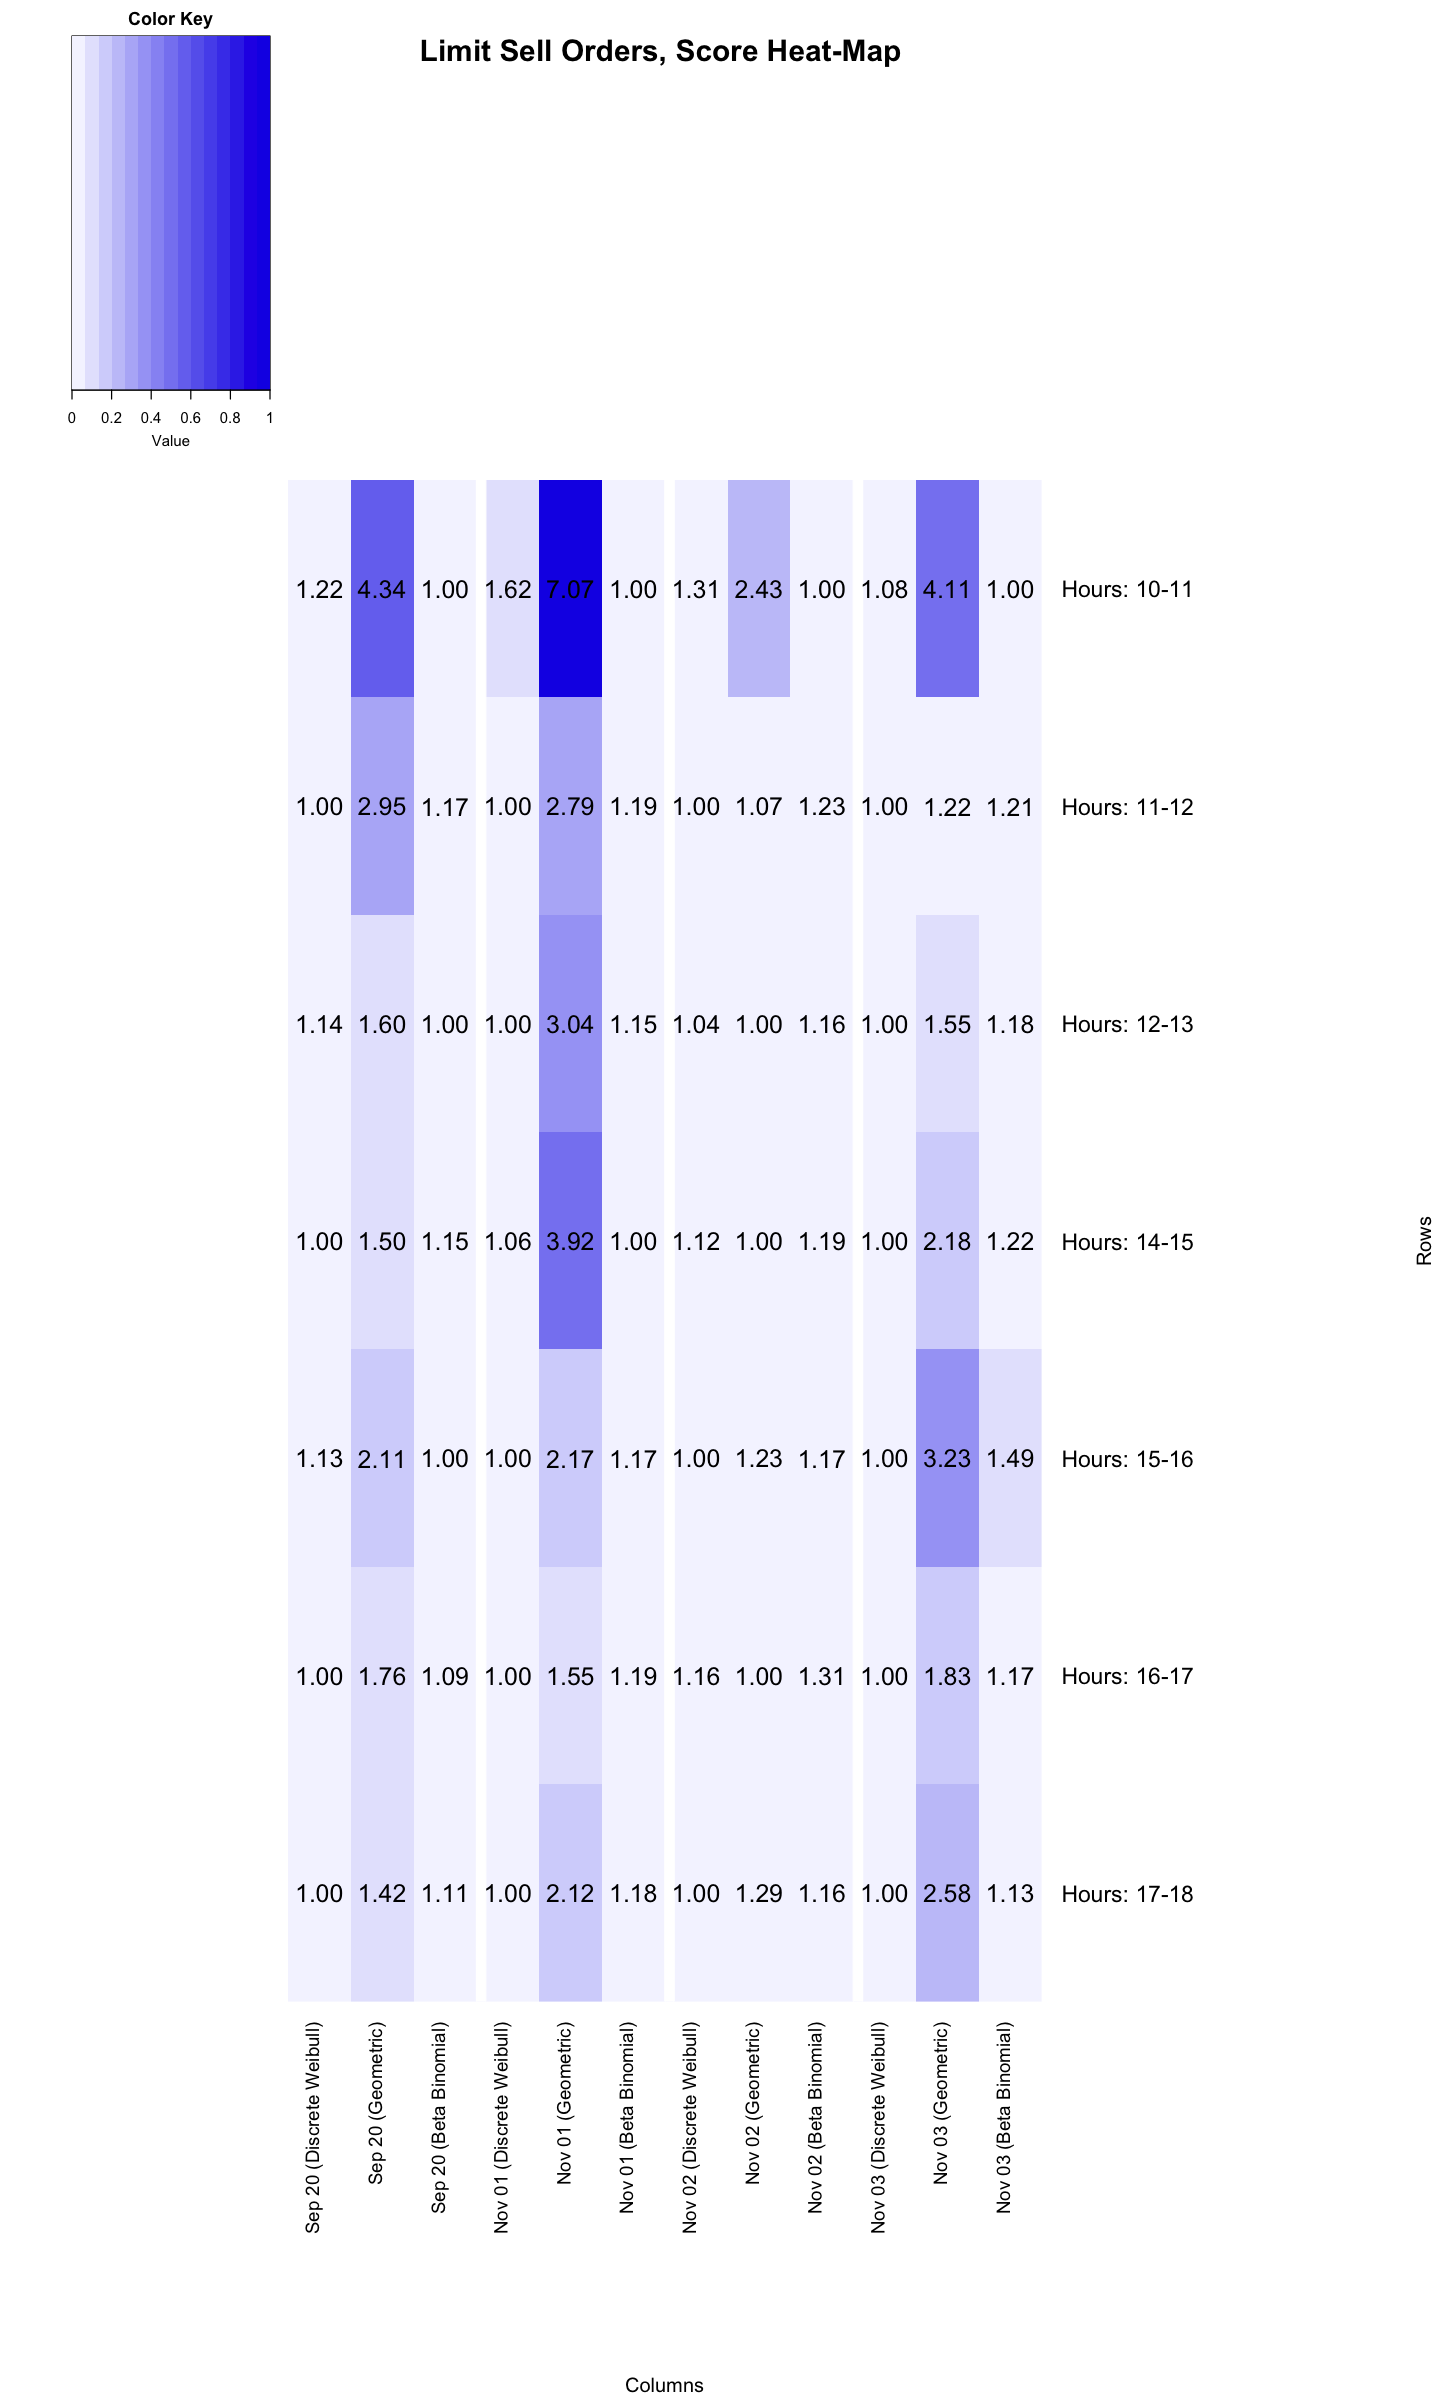

In [11]:
difs <- c()

for (i in 1:28) {
    min <- min(discrete_wei_L1[i], geometric_L1[i], bbinom_L1[i])
    difs <- c(difs, discrete_wei_L1[i]/min, geometric_L1[i]/min, bbinom_L1[i]/min)
}

mean_sd_mat = matrix(difs,
                     nrow=7,
                     ncol=12,
                     byrow = TRUE
                    )

xval <- formatC(mean_sd_mat, format="f", digits=2)
pal <- colorRampPalette(c(rgb(0.96,0.96,1), rgb(0.1,0.1,0.9)), space = "rgb")

mean_sd_mat <- (mean_sd_mat - min(mean_sd_mat)) / (max(mean_sd_mat) - min(mean_sd_mat))

dimnames(mean_sd_mat) = list(
    c("Hours: 10-11",
     "Hours: 11-12",
     "Hours: 12-13",
     "Hours: 14-15",
     "Hours: 15-16",
     "Hours: 16-17",
     "Hours: 17-18"),         # row names
    c("Sep 20 (Discrete Weibull)", "Sep 20 (Geometric)", "Sep 20 (Beta Binomial)",
      "Nov 01 (Discrete Weibull)", "Nov 01 (Geometric)", "Nov 01 (Beta Binomial)",
      "Nov 02 (Discrete Weibull)", "Nov 02 (Geometric)", "Nov 02 (Beta Binomial)",
      "Nov 03 (Discrete Weibull)", "Nov 03 (Geometric)", "Nov 03 (Beta Binomial)"
     )
)



#Plot the matrix
x_hm <- heatmap.2(mean_sd_mat, 
                  Rowv=FALSE, 
                  Colv=FALSE, 
                  dendrogram="none", 
                  main="Limit Sell Orders, Score Heat-Map ", 
                  xlab="Columns", 
                  ylab="Rows", 
                  col=pal, density.info = "none",
                  tracecol="#303030", trace="none", 
                  cellnote=xval, notecol="black", notecex=1.5, keysize = 1, margins=c(20, 20),
                 colsep=c(3,6,9), sepwidth=c(0.15))

### Hourly Cancel Buy Orders,  Probability Density Function

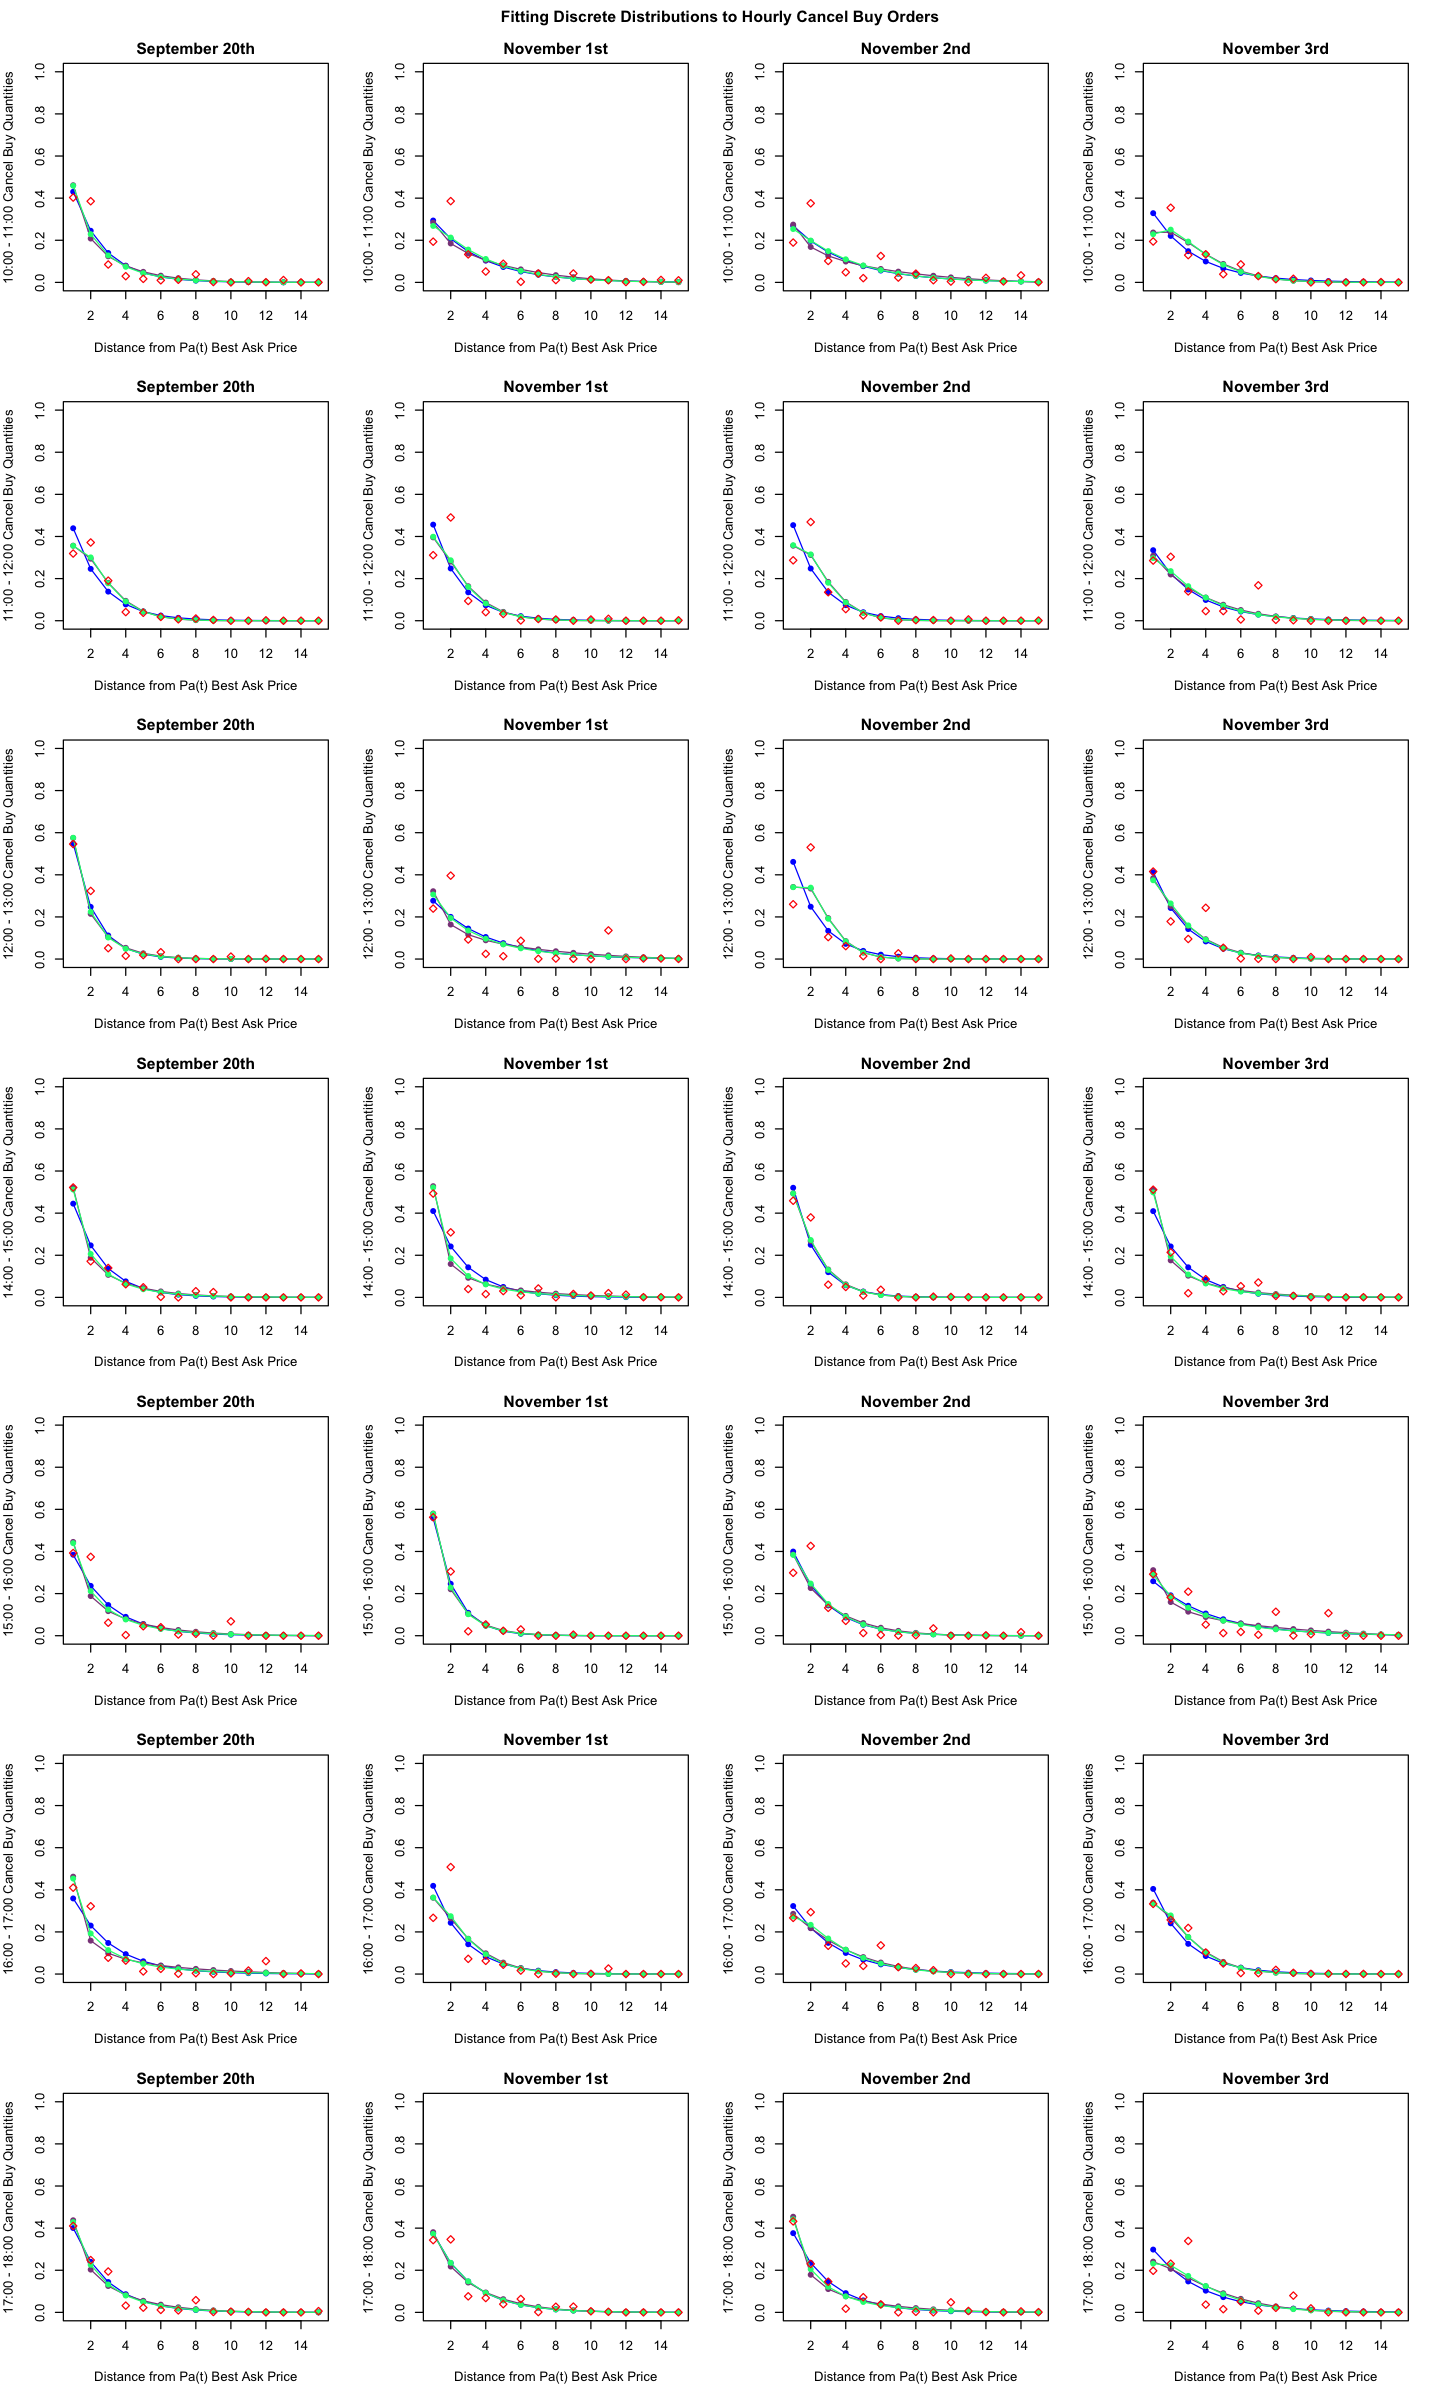

In [42]:
options(warn=-1)

discrete_wei_L1 <- c()
geometric_L1 <- c()
bbinom_L1 <- c()

# PDF
options(repr.plot.width=12, repr.plot.height=20)
names <- c("September 20th", "November 1st", 
           "November 2nd", "November 3rd")
hours <- c('10:00 - 11:00', '11:00 - 12:00', '12:00 - 13:00', '14:00 - 15:00', '15:00 - 16:00', '16:00 - 17:00',
        '17:00 - 18:00')
par(mfrow = c(7, 4), oma=c(0,0,2,0))  

for (i in 1:7) {
    for (k in 1:4) {
        par(mar=c(5,4,2,2))
        count_data <- rep(ticks, daily_q[[k]][i+18, 2:16])
        
        # Geometric Distribution
        
        p <- mle_exp(count_data)
        
        plot(1:15, ((1-p)^(0:14))*p, 
             col="blue", pch=16, ylim=range(c(0,1)), 
             axes = FALSE, xlab = "", ylab = "")

        lines(1:15, ((1-p)^(0:14))*p, col="blue")
        
        diff <- sum(abs((((1-p)^(0:14))*p) - (daily_q[[k]][i+18, 2:16]/sum(daily_q[[k]][i+18, 2:16]))))
        geometric_L1 <- c(geometric_L1, diff)
       
        # Beta - Binomial Distribtuion
        
        par(new = TRUE)
        
        params <- bb_mle_optimizer(rep(0:14, daily_q[[k]][i+18, 2:16]), 14)
        a <- params[1]
        b <- params[2]
        
        plot(1:15, bb_pmf(14,0:14,a,b), 
             col="orchid4", pch=16, ylim=range(c(0,1)), 
             axes = FALSE, xlab = "", ylab = "")

        lines(1:15, bb_pmf(14,0:14,a,b), col="orchid4")
        
        diff <- sum(abs(bb_pmf(14,0:14,a,b) - (daily_q[[k]][i+18, 2:16]/sum(daily_q[[k]][i+18, 2:16]))))
        bbinom_L1 <- c(bbinom_L1, diff)
        
        # Discrete Weibull Distribution
        
        par(new = TRUE)
        
        params <- estdweibull(count_data, method = "ML", zero = FALSE, eps = 1e-04, nmax=1000)
        q <- params[1]
        b <- params[2]
        
        plot(1:15, q^((0:14)^b) - q^((1:15)^b), 
             col="springgreen", pch=16, ylim=range(c(0,1)), 
             axes = FALSE, xlab = "", ylab = "")
        
        lines(1:15, q^((0:14)^b) - q^((1:15)^b), col="springgreen")
        
        diff <- sum(abs((q^((0:14)^b) - q^((1:15)^b)) - (daily_q[[k]][i+18, 2:16]/sum(daily_q[[k]][i+18, 2:16]))))
        discrete_wei_L1 <- c(discrete_wei_L1, diff)
        
        # Density
        
        par(new = TRUE)
        
        plot(1:15, daily_q[[k]][i+18, 2:16]/sum(daily_q[[k]][i+18, 2:16]),col="red", 
             xlab = "Distance from Pa(t) Best Ask Price",
             ylab = paste(hours[i], "Cancel Buy Quantities"), main = names[k],
             pch=23, ylim=range(c(0,1)))
            
    }
}
        
title("Fitting Discrete Distributions to Hourly Cancel Buy Orders", outer = TRUE) 

options(warn=0)

### Fit Tests: L1 norms of difference in PMFs of Hourly Cancel Buy Orders

<img src="cancel_buy_l1.png" style="width: 1000px;"/>

### Fit Scores

For fit tests on mean orders, hourly limit orders and hourly cancel orders. We divide each row in the same day with the minimum value in that row and we find the scores. 

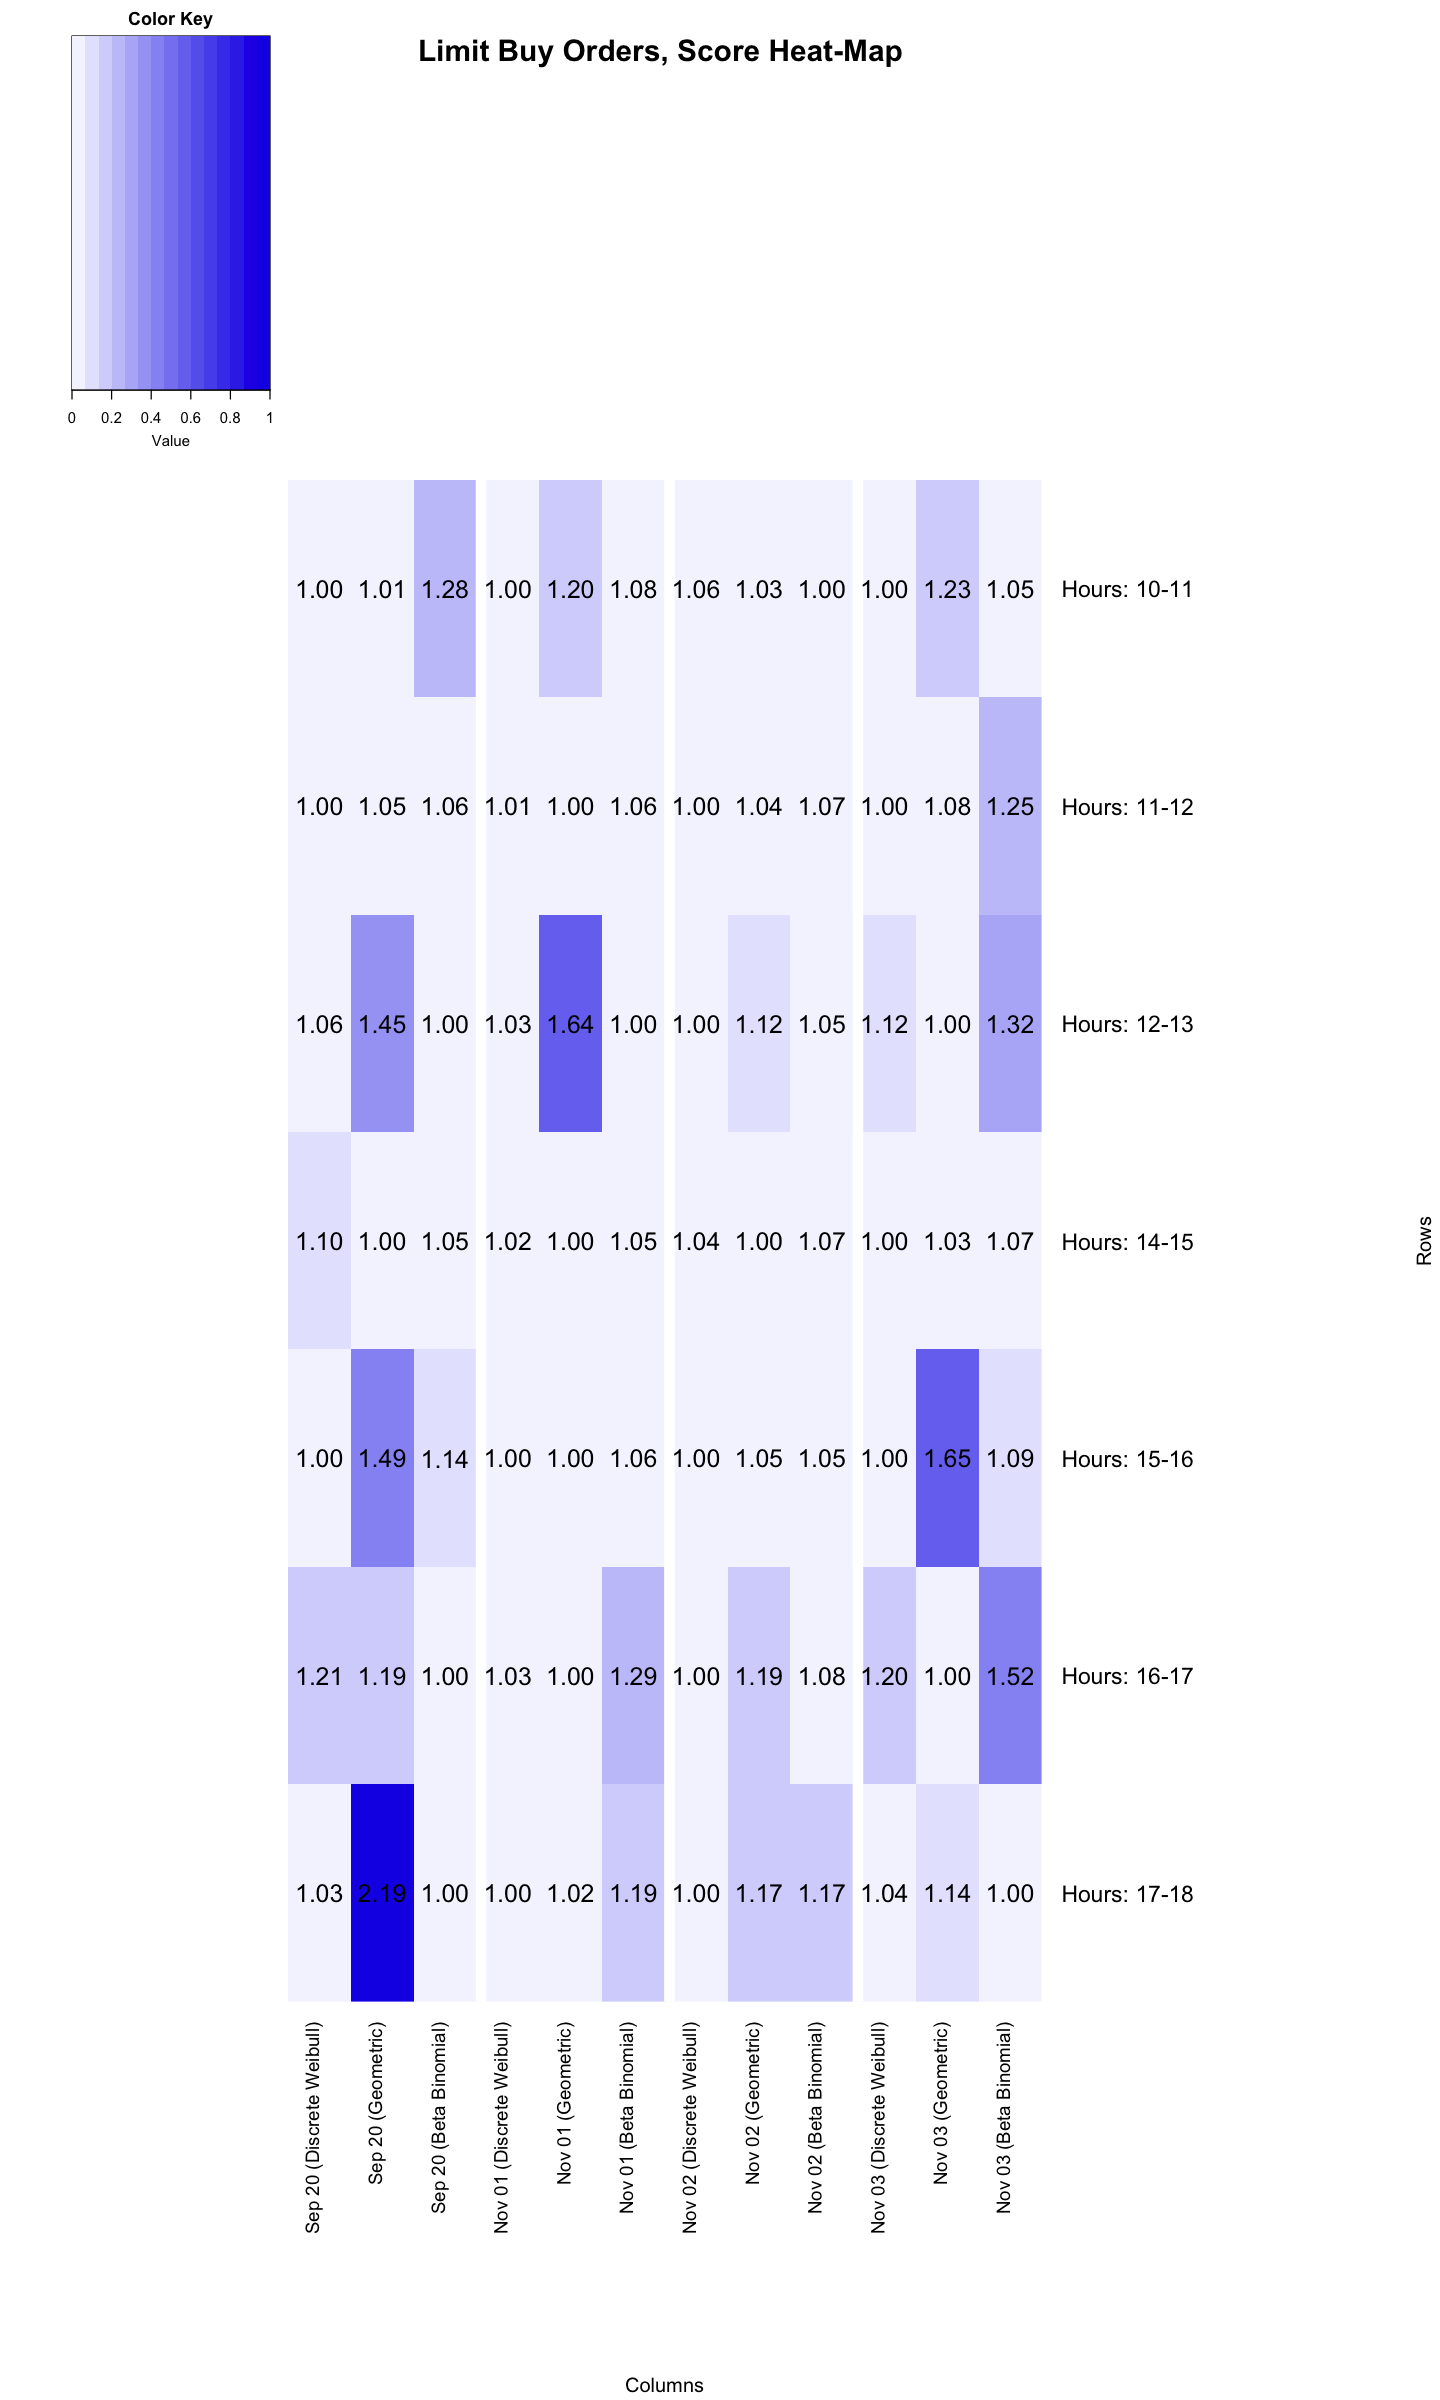

In [48]:
difs <- c()

for (i in 1:28) {
    min <- min(discrete_wei_L1[i], geometric_L1[i], bbinom_L1[i])
    difs <- c(difs, discrete_wei_L1[i]/min, geometric_L1[i]/min, bbinom_L1[i]/min)
}

mean_sd_mat = matrix(difs,
                     nrow=7,
                     ncol=12,
                     byrow = TRUE
                    )

xval <- formatC(mean_sd_mat, format="f", digits=2)
pal <- colorRampPalette(c(rgb(0.96,0.96,1), rgb(0.1,0.1,0.9)), space = "rgb")

mean_sd_mat <- (mean_sd_mat - min(mean_sd_mat)) / (max(mean_sd_mat) - min(mean_sd_mat))

dimnames(mean_sd_mat) = list(
    c("Hours: 10-11",
     "Hours: 11-12",
     "Hours: 12-13",
     "Hours: 14-15",
     "Hours: 15-16",
     "Hours: 16-17",
     "Hours: 17-18"),         # row names
    c("Sep 20 (Discrete Weibull)", "Sep 20 (Geometric)", "Sep 20 (Beta Binomial)",
      "Nov 01 (Discrete Weibull)", "Nov 01 (Geometric)", "Nov 01 (Beta Binomial)",
      "Nov 02 (Discrete Weibull)", "Nov 02 (Geometric)", "Nov 02 (Beta Binomial)",
      "Nov 03 (Discrete Weibull)", "Nov 03 (Geometric)", "Nov 03 (Beta Binomial)"
     )
)



#Plot the matrix
x_hm <- heatmap.2(mean_sd_mat, 
                  Rowv=FALSE, 
                  Colv=FALSE, 
                  dendrogram="none", 
                  main="Limit Buy Orders, Score Heat-Map ", 
                  xlab="Columns", 
                  ylab="Rows", 
                  col=pal, density.info = "none",
                  tracecol="#303030", trace="none", 
                  cellnote=xval, notecol="black", notecex=1.5, keysize = 1, margins=c(20, 20),
                 colsep=c(3,6,9), sepwidth=c(0.15))

### Hourly Cancel Sell Orders,  Probability Density Function

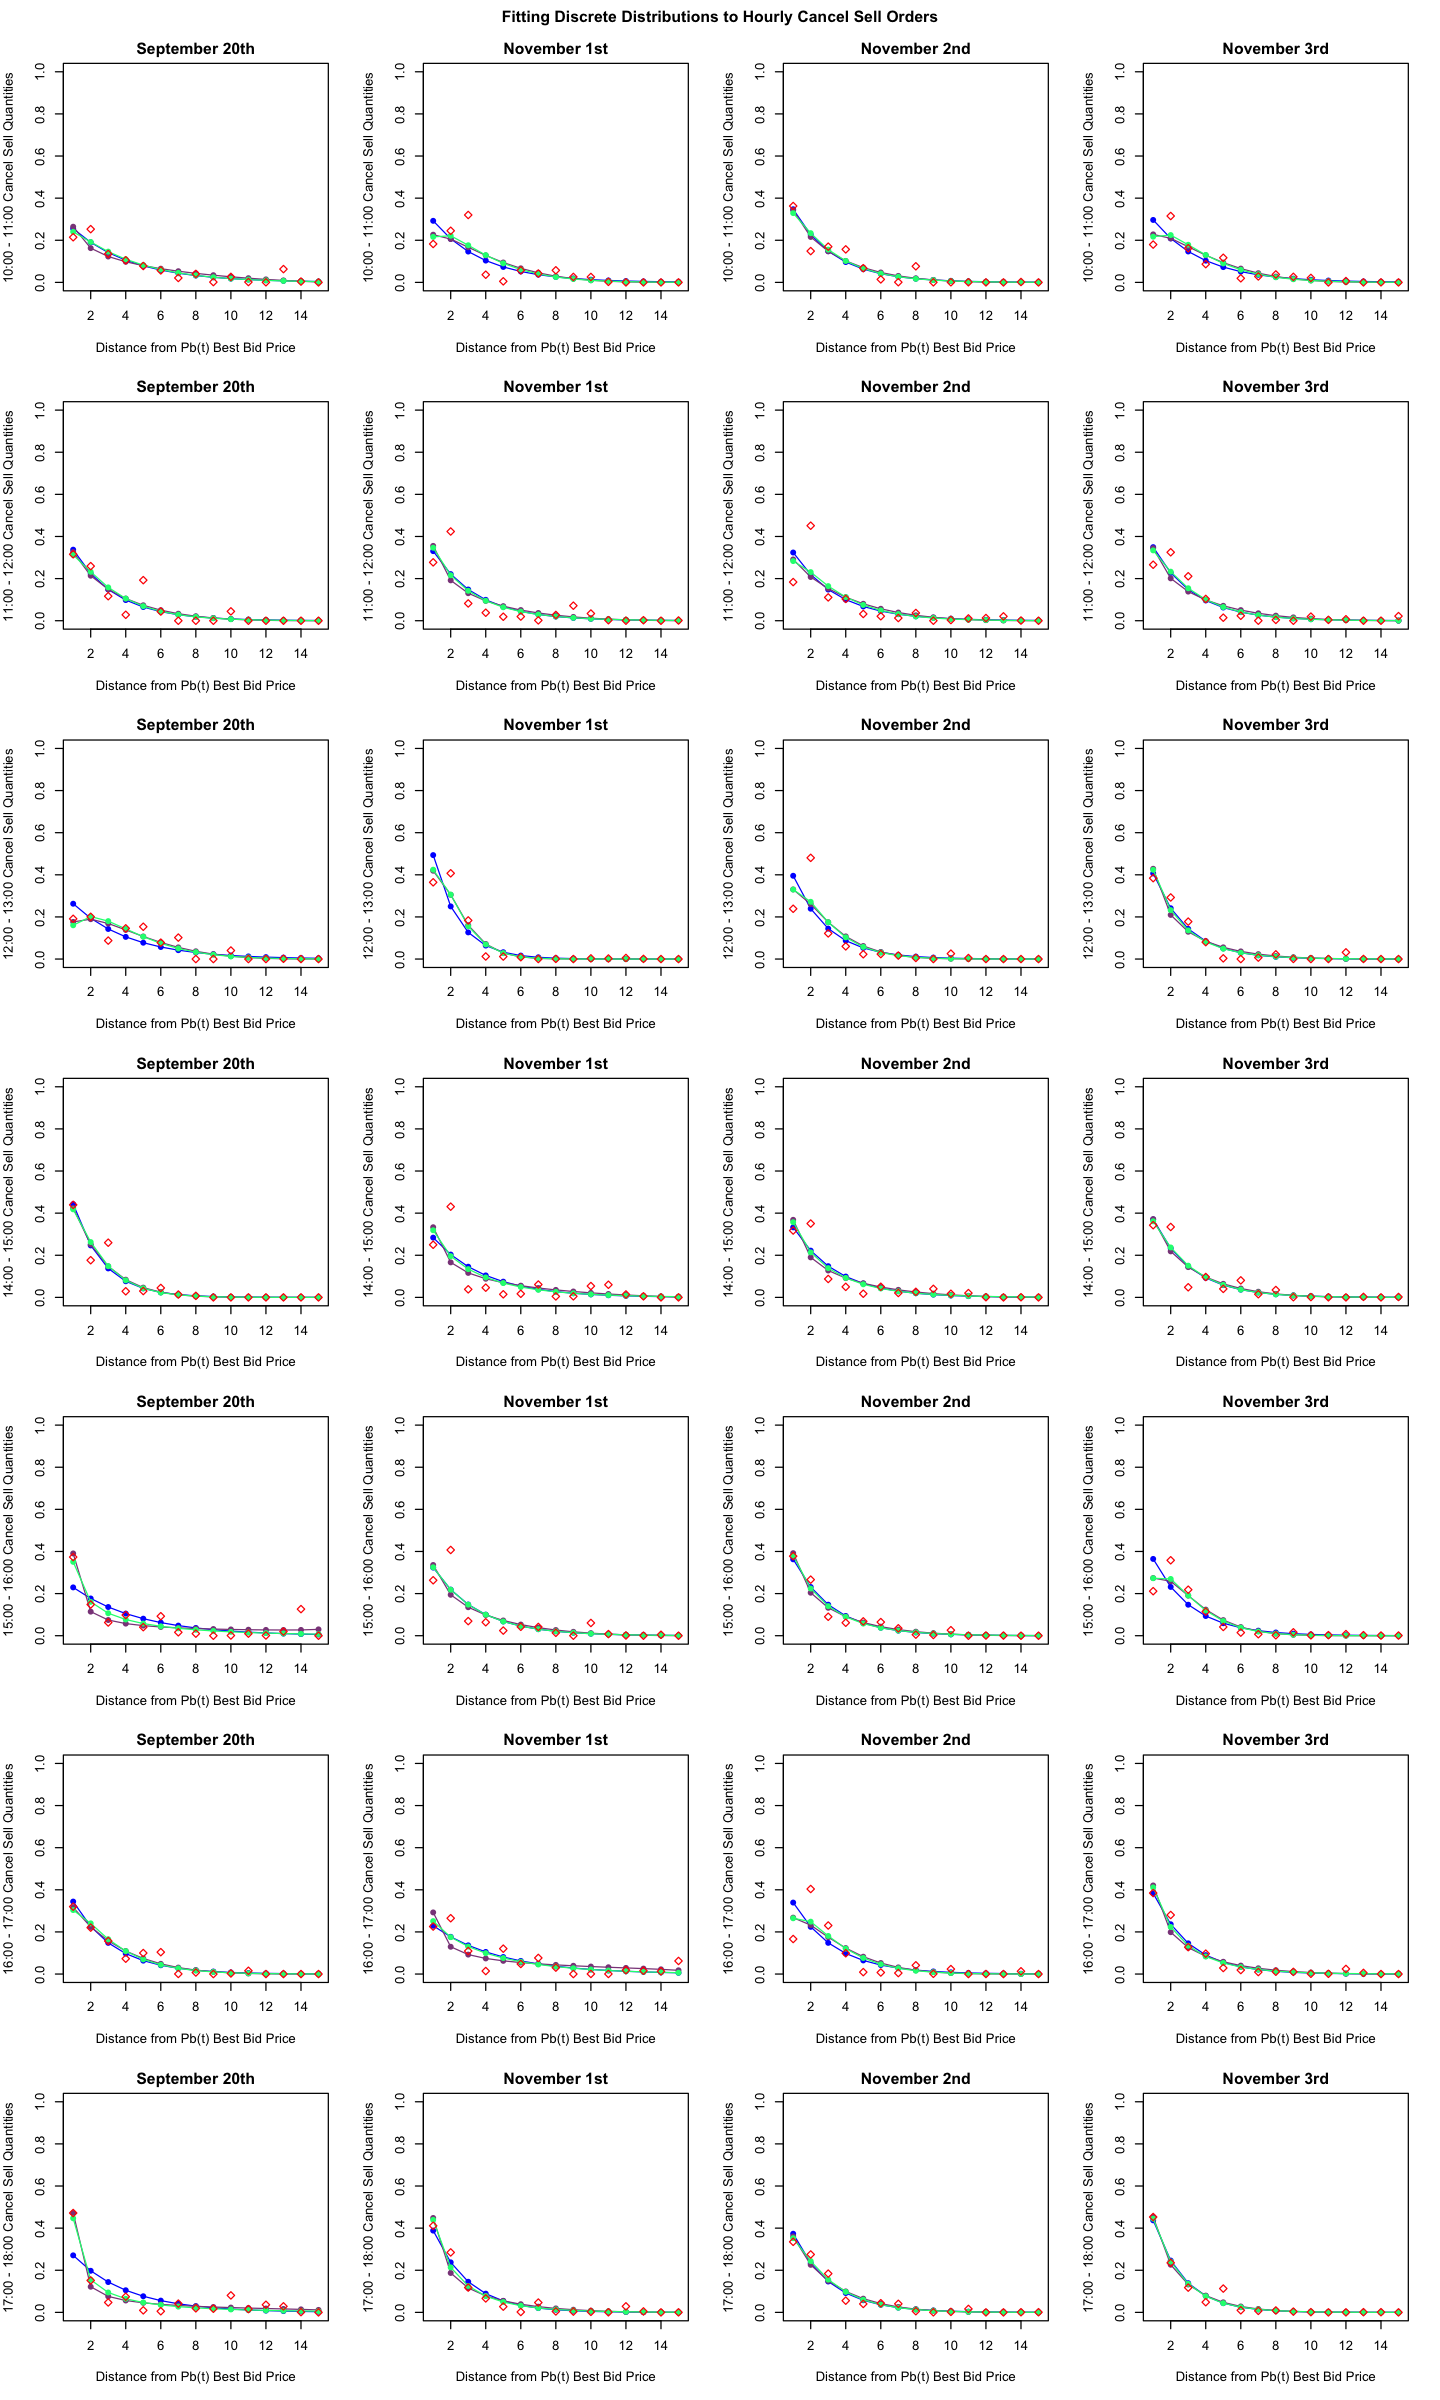

In [44]:
options(warn=-1)

discrete_wei_L1 <- c()
geometric_L1 <- c()
bbinom_L1 <- c()

# PDF
options(repr.plot.width=12, repr.plot.height=20)
names <- c("September 20th", "November 1st", 
           "November 2nd", "November 3rd")
hours <- c('10:00 - 11:00', '11:00 - 12:00', '12:00 - 13:00', '14:00 - 15:00', '15:00 - 16:00', '16:00 - 17:00',
        '17:00 - 18:00')
par(mfrow = c(7, 4), oma=c(0,0,2,0))  

for (i in 1:7) {
    for (k in 1:4) {
        par(mar=c(5,4,2,2))
        count_data <- rep(ticks, daily_q[[k]][i+25, 2:16])
        
        # Geometric Distribution
        
        p <- mle_exp(count_data)
        
        plot(1:15, ((1-p)^(0:14))*p, 
             col="blue", pch=16, ylim=range(c(0,1)), 
             axes = FALSE, xlab = "", ylab = "")

        lines(1:15, ((1-p)^(0:14))*p, col="blue")
        
        diff <- sum(abs((((1-p)^(0:14))*p) - (daily_q[[k]][i+25, 2:16]/sum(daily_q[[k]][i+25, 2:16]))))
        geometric_L1 <- c(geometric_L1, diff)
       
        # Beta - Binomial Distribtuion
        
        par(new = TRUE)
        
        params <- bb_mle_optimizer(rep(0:14, daily_q[[k]][i+25, 2:16]), 14)
        a <- params[1]
        b <- params[2]
        
        plot(1:15, bb_pmf(14,0:14,a,b), 
             col="orchid4", pch=16, ylim=range(c(0,1)), 
             axes = FALSE, xlab = "", ylab = "")

        lines(1:15, bb_pmf(14,0:14,a,b), col="orchid4")
        
        diff <- sum(abs(bb_pmf(14,0:14,a,b) - (daily_q[[k]][i+25, 2:16]/sum(daily_q[[k]][i+25, 2:16]))))
        bbinom_L1 <- c(bbinom_L1, diff)
        
        # Discrete Weibull Distribution
        
        par(new = TRUE)
        
        params <- estdweibull(count_data, method = "ML", zero = FALSE, eps = 1e-04, nmax=1000)
        q <- params[1]
        b <- params[2]
        
        plot(1:15, q^((0:14)^b) - q^((1:15)^b), 
             col="springgreen", pch=16, ylim=range(c(0,1)), 
             axes = FALSE, xlab = "", ylab = "")
        
        lines(1:15, q^((0:14)^b) - q^((1:15)^b), col="springgreen")
        
        diff <- sum(abs((q^((0:14)^b) - q^((1:15)^b)) - (daily_q[[k]][i+25, 2:16]/sum(daily_q[[k]][i+25, 2:16]))))
        discrete_wei_L1 <- c(discrete_wei_L1, diff)
        
        # Density
        
        par(new = TRUE)
        
        plot(1:15, daily_q[[k]][i+25, 2:16]/sum(daily_q[[k]][i+25, 2:16]),col="red", 
             xlab = "Distance from Pb(t) Best Bid Price",
             ylab = paste(hours[i], "Cancel Sell Quantities"), main = names[k],
             pch=23, ylim=range(c(0,1)))
            
    }
}
        
title("Fitting Discrete Distributions to Hourly Cancel Sell Orders", outer = TRUE) 

options(warn=0)

### Fit Tests: L1 norms of difference in PMFs of Hourly Cancel Sell Orders

<img src="cancel_sell_l1.png" style="width: 1000px;"/>

### Fit Scores

For fit tests on mean orders, hourly limit orders and hourly cancel orders. We divide each row in the same day with the minimum value in that row and we find the scores. 

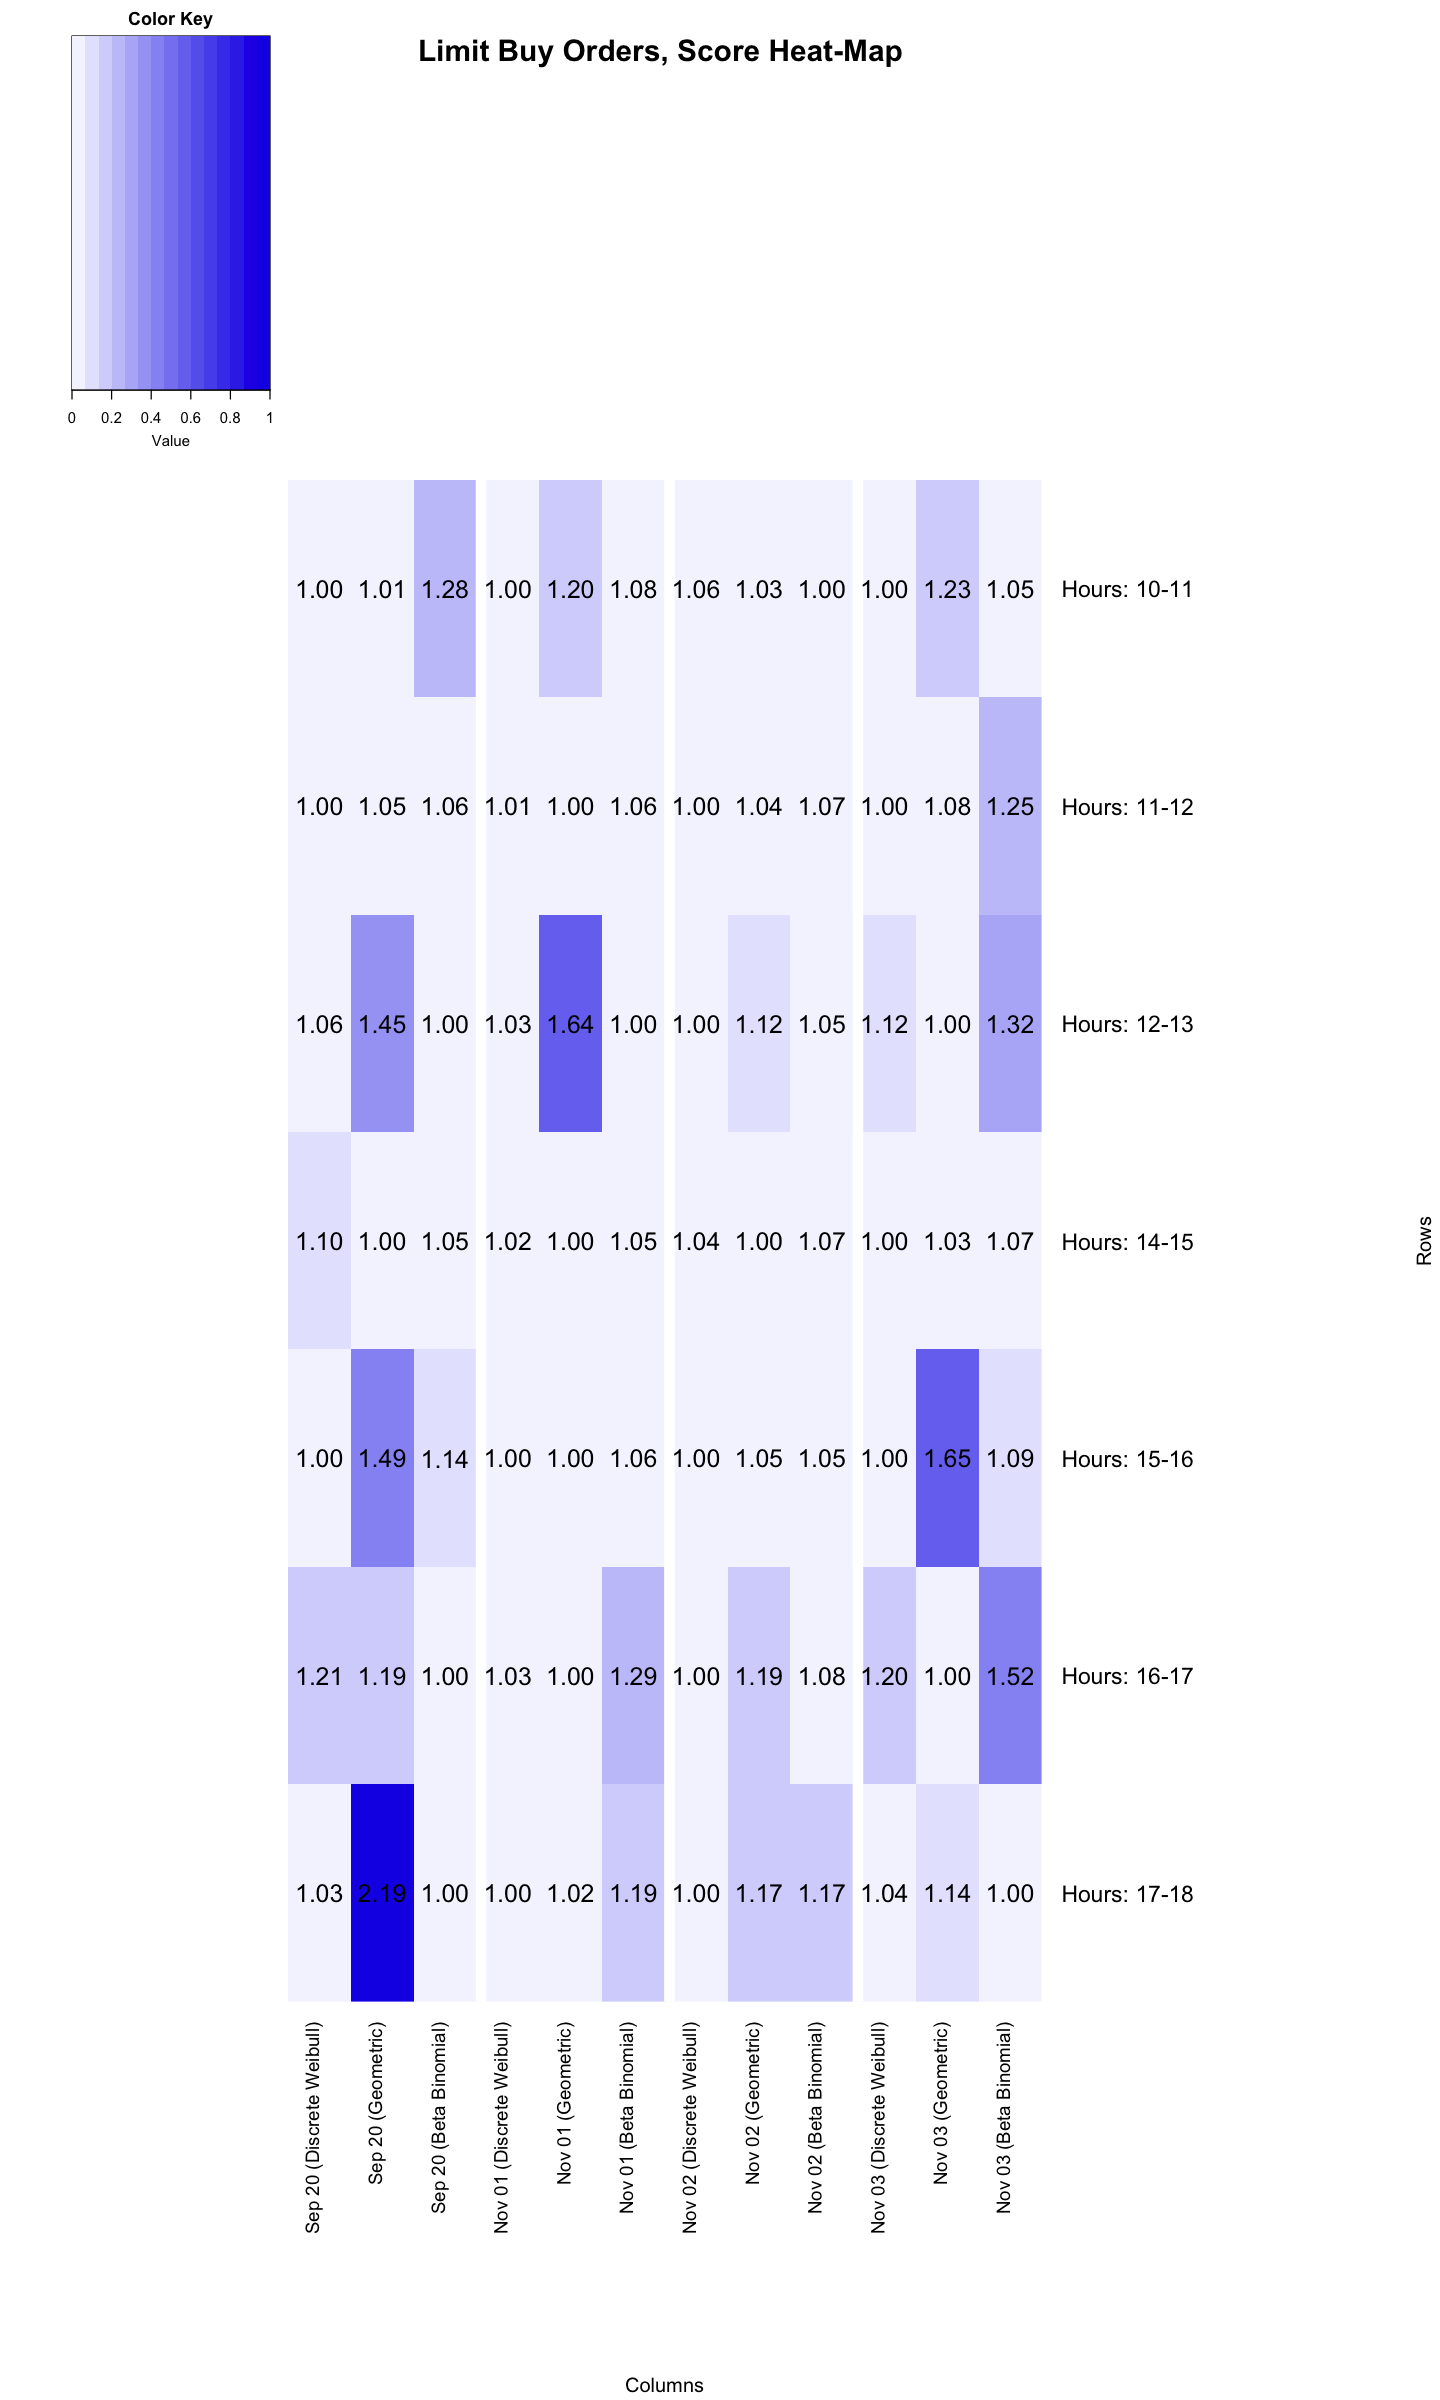

In [47]:
difs <- c()

for (i in 1:28) {
    min <- min(discrete_wei_L1[i], geometric_L1[i], bbinom_L1[i])
    difs <- c(difs, discrete_wei_L1[i]/min, geometric_L1[i]/min, bbinom_L1[i]/min)
}

mean_sd_mat = matrix(difs,
                     nrow=7,
                     ncol=12,
                     byrow = TRUE
                    )

xval <- formatC(mean_sd_mat, format="f", digits=2)
pal <- colorRampPalette(c(rgb(0.96,0.96,1), rgb(0.1,0.1,0.9)), space = "rgb")

mean_sd_mat <- (mean_sd_mat - min(mean_sd_mat)) / (max(mean_sd_mat) - min(mean_sd_mat))

dimnames(mean_sd_mat) = list(
    c("Hours: 10-11",
     "Hours: 11-12",
     "Hours: 12-13",
     "Hours: 14-15",
     "Hours: 15-16",
     "Hours: 16-17",
     "Hours: 17-18"),         # row names
    c("Sep 20 (Discrete Weibull)", "Sep 20 (Geometric)", "Sep 20 (Beta Binomial)",
      "Nov 01 (Discrete Weibull)", "Nov 01 (Geometric)", "Nov 01 (Beta Binomial)",
      "Nov 02 (Discrete Weibull)", "Nov 02 (Geometric)", "Nov 02 (Beta Binomial)",
      "Nov 03 (Discrete Weibull)", "Nov 03 (Geometric)", "Nov 03 (Beta Binomial)"
     )
)

#Plot the matrix
x_hm <- heatmap.2(mean_sd_mat, 
                  Rowv=FALSE, 
                  Colv=FALSE, 
                  dendrogram="none", 
                  main="Limit Buy Orders, Score Heat-Map ", 
                  xlab="Columns", 
                  ylab="Rows", 
                  col=pal, density.info = "none",
                  tracecol="#303030", trace="none", 
                  cellnote=xval, notecol="black", notecex=1.5, keysize = 1, margins=c(20, 20),
                 colsep=c(3,6,9), sepwidth=c(0.15))

### Comparison of the Standard Error of the Mean

For fit tests on mean orders, hourly limit orders and hourly cancel orders. We divide each row with the minimum value in that row and we find the scores. The lowest score shows the best fit for that sample. Then we take the mean and find standard deviation. As a result (mean +- (st.dev)/sample size) gives us the standard error of the mean of the scores.

In [46]:
means <- c("1,01626 +- 0,0111",
          "2,06506 +- 0,2975",
          "1,26694 +- 0,0296",
          "1,06167 +- 0,0272",
          "2,77719 +- 0,3069",
          "1,15769 +- 0,0240",
          "1,06715 +- 0,0253",
          "2,28825 +- 0,2532",
          "1,14288 +- 0,0207",
          "1,04557 +- 0,0127",
          "1,19137 +- 0,0508",
          "1,09323 +- 0,0158",
          "1,03343 +- 0,0107",
          "1,17712 +- 0,0520",
          "1,10858 +- 0,0233")

mean_sd_mat = matrix(means,
                     nrow=5,
                     ncol=3,
                     byrow = TRUE
                    )


dimnames(mean_sd_mat) = list(
    c("Mean Orders",
     "Limit Buy Hourly",
     "Limit Sell Hourly",
     "Cancel Buy Hourly",
     "Cancel Sell Hourly"
     ),         # row names
    c("Score (Discrete Weibull)", 
      "Score (Geometric)", 
      "Score (Beta Binomial)"
     )
)

mean_sd_mat

,Score (Discrete Weibull),Score (Geometric),Score (Beta Binomial)
Mean Orders,"1,01626 +- 0,0111","2,06506 +- 0,2975","1,26694 +- 0,0296"
Limit Buy Hourly,"1,06167 +- 0,0272","2,77719 +- 0,3069","1,15769 +- 0,0240"
Limit Sell Hourly,"1,06715 +- 0,0253","2,28825 +- 0,2532","1,14288 +- 0,0207"
Cancel Buy Hourly,"1,04557 +- 0,0127","1,19137 +- 0,0508","1,09323 +- 0,0158"
Cancel Sell Hourly,"1,03343 +- 0,0107","1,17712 +- 0,0520","1,10858 +- 0,0233"
